# Stochastic Processes Simulation - Browniean Motion, The Basics

Brownian motion is the building block of stochastic calculus and therefore, the key to simulating stochastic processes. Although is not easy to observe pure Brownian motions in real-world data, we can combine them and rescale them to build more complex processes that successfully approximate the data.

Wiener processes, the other name given to Brownian motions, can be used to build processes with different properties and behaviors.

In simple terms, Brownian motion is a continuous process such that its increments for any time scale are drawn from a normal distribution.

This is the reason why they are central in stochastic calculus. The normal distribution ticks most boxes for analytical properties, this is why it is at the center of continuous probability theory as well.

In this story, we will summarize the basics of Brownian motion and learn how to simulate them in Python. We will also learn how to simulate correlated N-dimensional Wiener processes.

## Definition

A process W, a continuos function of t, i.e. W = W(t) is a Brownian motion (Wiener process) if W(0) = 0 and if for all 0 = t_0 < t_1 < … < t_m the increments

$$ W_{t_{1}} - W_{t_{0}}, W_{t_{2}} - W_{t_{1}}, ... , W_{t_{m}} - W_{t_{m-1}}  $$ 

are independent and normally distributed. The mean of the distribution (normal) is zero and its variance is the time difference t_{i+1} - t_{i}.

As an example, if the increments are defined on a unit of time, then the distribution is the standard normal, zero mean, unit variance.

Generating a Brownian motion in Python is very easy. The following code generates the increments of a Wiener process (dW) discretely sampled in unit time as well as the process path (W):

In [6]:
from typing import Optional
import numpy as np

def get_dW(tau: int, random_state: Optional[int] = None) -> np.ndarray:
    """
    Sample T times from a normal distribution,
    to simulate discrete increments (dW) of a Brownian Motion.
    Optional random_state to reproduce results.
    """
    np.random.seed(random_state)
    return np.random.normal(0.0, 1.0, tau)

def get_W(tau: int, random_state: Optional[int] = None) -> np.ndarray:
    """
    Simulate a Brownian motion discretely samplet at unit time increments.
    Returns the cumulative sum
    """
    dw = get_dW(tau, random_state)
    dw_cs = dw.cumsum()
    return np.insert(dw_cs, 0,0)[:-1]

In [7]:
# As an example for T of 1000:

dw = get_dW(tau=1000)
w = get_W(tau=1000)

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

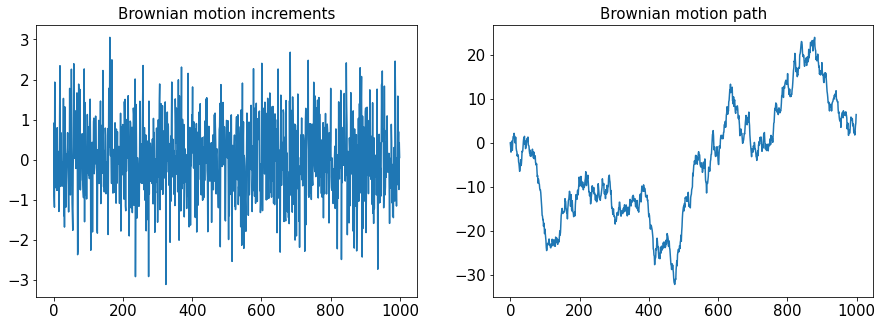

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 5))

title = "Brownian motion increments"
plt.subplot(1, 2, 1)
plt.plot(dw)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Brownian motion path"
plt.subplot(1, 2, 2)
plt.plot(w)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Correlated Processes

Brownian montition can be correlated to another Brownian motion. Let $W_{1}$ be a Brownian motion and $W_{3}$ another correlated to $W_{1}$, then:

$$ dW_{3,t} = \tau d W_{1,t} + \sqrt{1-\tau^2} dW_{2,t} $$

were $W_{2}$ is another independent Brownian motion. The correlation of $W_{3}$ and $W_{1}$ is $\tau$


Note that even though there is correlation between the two processes $W_{3}$ and $W_{1}$, there are still two sources of randomness, $W_{1}$ and $W_{2}$. This is something that often gets overlooked by strategies and models which try to leverage correlation to make predictions, correlation does not decrease the sources of randomness.

The following function takes the increments of a Brownian motion, dW, and generates a correlated Brownian motion. Returns the increments of such correlated process.

In [9]:
from typing import Optional
import numpy as np

def _get_correlated_dW(
    dW: np.ndarray, rho: float, random_state: Optional[int] = None
) -> np.ndarray:
    """
    Sample correlated discrete Brownian increments to given increments dW.
    """
    dW2 = get_dW(
        len(dW), random_state=random_state
    )  # generate Brownian icrements.
    if np.array_equal(dW2, dW):
        # dW cannot be equal to dW2.
        raise ValueError(
            "Brownian Increment error, try choosing different random state."
        )
    return rho * dW + np.sqrt(1 - rho ** 2) * dW2

However, we seldom want just a pair of correlated processes. Rather, we often require many process somehow correlated, an N-dimensional Wiener process.

The following algorithm’s idea is to first generate one Brownian motion, then, another correlated to the first one by ρ, the subsequent processes should be correlated by ρ to a random choice of the processes already generated.

The result is matrix of processes where each column represents one process.

In [12]:
from typing import List

def get_corr_dW_matrix(
    tau:int,
    n_procs:int,
    rho: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    2D array of n_procs discrete Brownian Motion increments dW.
    Each column of the array is one process.
    So that the resulting shape of the array is (T, n_procs).
        - T is the number of samples of each process.
        - The correlation constant rho is used to generate a new process,
            which has rho correlation to a random process already generated,
            hence rho is only an approximation to the pairwise correlation.
        - Optional random_state to reproduce results.
    """
    rng = np.random.default_rng(random_state)
    dws: list[np.ndarray] = []
    for i in range(n_procs):
        random_state_i = _get_random_state_i(random_state, i)
        if (i == 0) | (rho is None):
            dw_i = get_dW(tau, random_state=random_state_i)
        else:
            dw_corr_ref = _get_corr_ref_dW(dws, i, rng)
            dw_i = _get_correlated_dW(dw_corr_ref, rho, random_state_i)
        dws.append(dw_i)
    return np.asarray(dws).T

def _get_random_state_i(random_state: Optional[int], i: int) -> Optional[int]:
    """Add i to random_state is is int, else return None."""
    return random_state if random_state is None else random_state + i

def _get_corr_ref_dW(
    dWs: List[np.ndarray], i: int, rng: np.random.Generator
) -> np.ndarray:
    """
    Choose randomly a process (dW) the from the
    already generated processes (dWs).
    """
    random_proc_idx = rng.choice(i)
    return dWs[random_proc_idx]

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5,
        44.5, 46.5, 48.5, 50.5, 52.5]),
 [Text(0, 0.5, '0'),
  Text(0, 2.5, '2'),
  Text(0, 4.5, '4'),
  Text(0, 6.5, '6'),
  Text(0, 8.5, '8'),
  Text(0, 10.5, '10'),
  Text(0, 12.5, '12'),
  Text(0, 14.5, '14'),
  Text(0, 16.5, '16'),
  Text(0, 18.5, '18'),
  Text(0, 20.5, '20'),
  Text(0, 22.5, '22'),
  Text(0, 24.5, '24'),
  Text(0, 26.5, '26'),
  Text(0, 28.5, '28'),
  Text(0, 30.5, '30'),
  Text(0, 32.5, '32'),
  Text(0, 34.5, '34'),
  Text(0, 36.5, '36'),
  Text(0, 38.5, '38'),
  Text(0, 40.5, '40'),
  Text(0, 42.5, '42'),
  Text(0, 44.5, '44'),
  Text(0, 46.5, '46'),
  Text(0, 48.5, '48'),
  Text(0, 50.5, '50'),
  Text(0, 52.5, '52')])

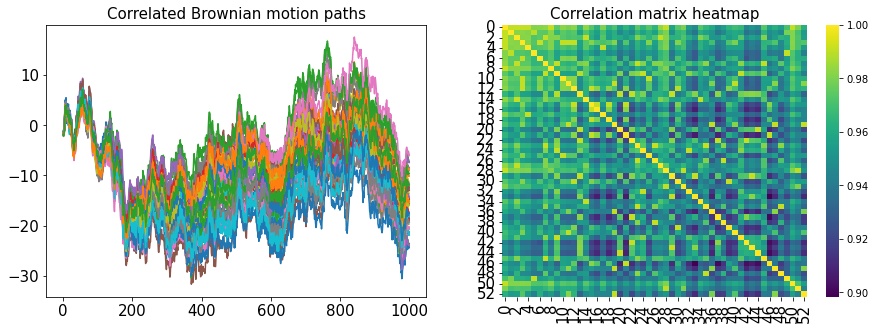

In [13]:
T = 1_000
n_procs = 53
rho = 0.99

corr_dWs = get_corr_dW_matrix(T, n_procs, rho)

#----------------------------------------------------------------
# plot

import matplotlib.pyplot as plt 
import seaborn as sns

fig = plt.figure(figsize=(15, 5))

# paths
title = "Correlated Brownian motion paths"
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(corr_dWs, axis=0))
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# correlation
title = "Correlation matrix heatmap"
plt.subplot(1, 2, 2)
sns.heatmap(np.corrcoef(corr_dWs, rowvar=False), cmap="viridis")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Diffusive processes:

The most general form in which we can use a Brownian motion to build more complex processes is the Ito diffusive process, with increments (stochastic differential equation):

$$ dX_{t} = a_{1}(X_t, t)dt + b_{1}(X_{t},t)dW_{t} $$

where $a_{1}$ and $b_{1}$ are functions of t (time) and the process itself. The first term corresponds to the deterministic part and the second term to the random part.

We are not going to dive deep into stochastic calculus (also known as Itô calculus) at this point, but is important to mention that the Brownian motions in such diffusive processes can be correlated, the same way as in the previous section. If the Brownian Motions (W_t) are correlated, then the Itô processes (X_t) are correlated.

# Stochastic Processes Simulation - The Ornstein Uhlenbeck Proceses

The quest for stationarity. Doesn’t matter if we want to perform statistical inference or fit a machine learning model, we always seem to be searching for stationary features, stationary explanatory variables and well, stationary everything.

When we deal with indexed random variables stationarity means stationary stochastic processes.

In this story, we will discuss the Ornstein-Uhlenbeck process. The canonical process among the stationary stochastic processes. This process is not just stationary but also normally distributed. If only time-series features behaved like this.

In the upcoming sections, we will simulate the Ornstein-Uhlenbeck process, learn how to estimate its parameters from data, and lastly, simulate multiple correlated processes. The idea is that by the end of this story you can take with you a complete neat mini-library for Ornstein-Uhlenbeck simulations.

## The equation of the process

The Ornstein-Uhlenbeck (OU for short) process satisfies the stochastic differential equation (SDE):

$$ dX_{t} = \alpha (\gamma - X_{t})dt + \beta dW_{t} $$

were $W_{t}$ is a brownian motion, and $\alpha$ and $\beta$ are positive constants.

The deterministic part (the drift of the process) which is the time differential term is what causes the mean reversion. When X_t is larger than $\gamma$ (the asymptotic mean), the drift is negative, pulling the process back to the mean, when X_t is smaller than $\gamma$, the opposite happens. $\alpha$, the mean-reversion parameter, controls the magnitude of the drift, so higher values will cause the process to mean-revert more aggressively. Finally, $\beta$ controls the random shocks of the process. Note that for very high values of β, the process is, asymptotically, a rescaled Brownian motion as the drift no longer has a significant effect.

There are two main reasons why this process is used as the canonical process for stationary processes:

- The stochastic differential equation is integrable in closed-form (and we love that).
- The process path is normally distributed. So if Brownian motion is at the center of stochastic processes because its increments are normally distributed, then the OU process is at the center of mean-reverting processes because its path is normally distributed.

The solution to the SDE is:

$$ X_{t} = X_{0}e^{-\alpha t} + \gamma (1-e^{-\alpha t}) + \beta e^{-\alpha t} \int_{a}^{b} e^{\alpha s} dW_{s} $$

it's asymptotic mean and variance are $\gamma$ and $\beta ^2 /2\alpha$ respectively. Hence, the distribution of the process is $N(\gamma , \beta ^2 /2\alpha)$

## Simulating the process

To simulate the process we need to convert the solution of the SDE to a discrete vectorial equation, each unit time of the process is an index of a vector.

We let t = (0, 1, 2, …, T-1), where T is the sample size. We build the arrays for the exponentials and then approximate the integral. To approximate the integral we use the cumulative sum. Note that this approximation for the integral is not suitable for very small sample sizes, so letting the sample size be greater than about 100 is a good idea.

Lets code this.

First we will define the parameters in a dataclass. Passing around many parameters often gets messy, it’s cleaner to pass them in an object of their own:

In [14]:
from dataclasses import dataclass

@dataclass
class OUParams:
    alpha: float # mean reversion parameter
    gamma: float # asymptotic mean
    beta: float # Brownian motion scale (standard deviation)

To generate the OU process simulation we will use the code to generate Brownian motions from the first story of the series. 

In [15]:
from typing import Optional
import numpy as np

def get_OU_process(
    T: int,
    OU_params: OUParams,
    X_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is the sample size.
    - Ou_params is an instance of OUParams dataclass.
    - X_0 the initial value for the process, if None, then X_0 is taken
        to be gamma (the asymptotic mean).
    Returns a 1D array.
    """
    t = np.arange(T, dtype=np.float128) # float to avoid np.exp overflow
    exp_alpha_t = np.exp(-OU_params.alpha * t)
    dW = get_dW(T, random_state)
    integral_W = _get_integal_W(t, dW, OU_params)
    _X_0 = _select_X_0(X_0, OU_params)
    return (
        _X_0 * exp_alpha_t
        + OU_params.gamma * (1 - exp_alpha_t)
        + OU_params.beta * exp_alpha_t * integral_W
    )


def _select_X_0(X_0_in: Optional[float], OU_params: OUParams) -> float:
    """Returns X_0 input if not none, else gamma (the long term mean)."""
    return X_0_in if X_0_in is not None else OU_params.gamma


def _get_integal_W(
    t: np.ndarray, dW: np.ndarray, OU_params: OUParams
) -> np.ndarray:
    """Integral with respect to Brownian Motion (W), ∫...dW."""
    exp_alpha_s = np.exp(OU_params.alpha * t)
    integral_W = np.cumsum(exp_alpha_s * dW)
    return np.insert(integral_W, 0, 0)[:-1]

(array([-0.01 , -0.008, -0.006, -0.004, -0.002,  0.   ,  0.002,  0.004,
         0.006,  0.008,  0.01 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

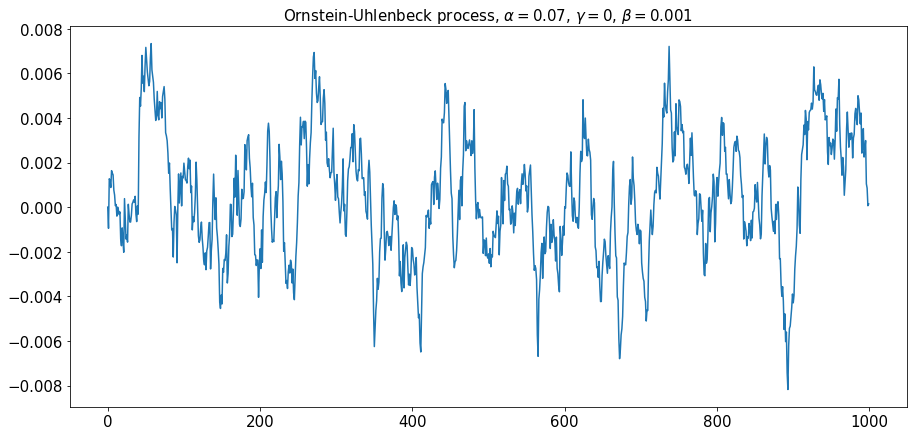

In [16]:
# Lets simulate an OU process:

OU_params = OUParams(alpha=0.07, gamma=0.0, beta=0.001)
OU_proc = get_OU_process(1_000, OU_params)

#----------------------------------------------------
# plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))

title = "Ornstein-Uhlenbeck process, "
title += r"$\alpha=0.07$, $\gamma = 0$, $\beta = 0.001$"
plt.plot(OU_proc)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Estimating the parameters from data

To estimate the OU parameters from a given process we use ordinary least squares (OLS) regression.

We approximate the stochastic differential equation by a discrete equation (the time series way), known as the Euler-Maruyama method (the random difference ΔX_t is taken as a forward difference):

$$ \Delta X_{t} = \alpha \gamma \Delta t - \alpha X_{t} \Delta t + \beta \epsilon_{t}  $$

Furthermore is we make $\Delta t = 1$ then:

$$ \Delta X_{t} = \alpha \gamma - \alpha X_{t} + \beta \epsilon_{t}  $$

were $\epsilon$ is the standard normal. Now it’a easy to see the regression specification, i.e. an equation of the form y = a + b X + $\epsilon$.

The following function performs the regression and estimates the OU parameters:

In [17]:
from sklearn.linear_model import LinearRegression

def estimate_OU_params(X_t: np.ndarray) -> OUParams:
    """
    Estimate OU params from OLS regression.
    - X_t is a 1D array.
    Returns instance of OUParams.
    """
    y = np.diff(X_t)
    X = X_t[:-1].reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X, y)
    # regression coeficient and constant
    alpha = -reg.coef_[0]
    gamma = reg.intercept_ / alpha
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    beta = np.std(y - y_hat)
    return OUParams(alpha, gamma, beta)

In [19]:
# Let’s test it with a simulated process to see if we can recover the OU params.

OU_params = OUParams(alpha=0.07, gamma=0.0, beta=0.001)
OU_proc = get_OU_process(100_000, OU_params, random_state=7)

OU_params_hat = estimate_OU_params(OU_proc)
print(OU_params_hat)

OUParams(alpha=0.06845699877932067, gamma=-3.9905935875610906e-05, beta=0.00092785693546220497295)


We get:

alpha=0.06845699877932063, gamma=-3.9905935875610906e-05, beta=0.00092785693546220497295,

the estimation is not perfect, but is good enough. To recover the true parameters we should estimate them in many samples, the averages will converge closer to the real parameters.

## Corelated processes

As we saw in the first part of the series, Itô diffusive processes’ random terms can be correlated. So naturally we want to have a way to create correlated OU processes. This will be useful in many models.

So we use the correlated Brownian motions matrix that we coded in part 1 of the series and use those processes to built the OU processes.

There are two main functionalities that we may want here:

- All processes have the same OU parameters and they are correlated.
- Every process has different OU parameters but processes are correlated.

We achieve this by letting the “OU_params” argument in the following code take two different types. If it is an instance of “OUParams” then it’s case 1; if it is a tuple of instances of “OUParams” then it’s case 2.

In [21]:
from typing import Optional, Union, Tuple

import numpy as np


def get_corr_OU_procs(
    T: int,
    OU_params: Union[OUParams, Tuple[OUParams, ...]],
    n_procs: Optional[int] = None,
    rho: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    Simulate correlated OU processes, correlation (rho) can be 0 or None.
    - T is the sample size of the processes.
    - OU_params can be a an instance of OUParams, in that case
        all processes have the same parameters. It can also be a tuple,
        in that case each process will have the parameters in the tuple,
        each column in the resulting 2D array corresponds to the tuple index.
    - n_procs is ignored if OU_params is tuple, else, corresponds to the number
        of processes desired. If OU_params is not tuple and n_procs is None, will
        raise ValueError.
    - rho is the correlation coefficient.
    - random_state to reproduce results.
    """
    _n_procs = _get_n_procs(OU_params, n_procs)
    corr_dWs = get_corr_dW_matrix(
        T, _n_procs, rho, random_state
    )
    is_OU_params_tpl = _is_OU_params_tuple(OU_params)
    OU_procs = []
    for i in range(_n_procs):
        OU_params_i = _get_OU_params_i(OU_params, i, is_OU_params_tpl)
        dW_i = corr_dWs[:, i]
        OU_procs.append(_get_OU_process_i(T, OU_params_i, dW_i))
    return np.asarray(OU_procs).T


def _is_OU_params_tuple(
    OU_params: Union[OUParams, Tuple[OUParams, ...]]
) -> bool:
    """
    Check is OU_params is a tuple of params,
    return bool.
    """
    return isinstance(OU_params, tuple)


def _get_n_procs(
    OU_params: Union[OUParams, Tuple[OUParams, ...]], n_procs: Optional[int]
) -> int:
    """
    Define the number of processes, if Ou_params is a tuple the
    number of processes is the lenght of the tuple. If it is not a tuple
    then it is the "n_procs" supplied as argument,
    if it is None will raise ValueError.
    """
    if _is_OU_params_tuple(OU_params):
        return len(OU_params)  # type: ignore
    elif n_procs is None:
        raise ValueError("If OU_params is not tuple, n_procs cannot be None.")
    return n_procs


def _get_OU_params_i(
    OU_params: Union[OUParams, Tuple[OUParams, ...]],
    i: int,
    is_OU_params_tpl: bool,
) -> OUParams:
    """
    Returns the ith value of the OU_params tuple if it is a tuple,
    otherwise returns OUParams.
    """
    return OU_params[i] if is_OU_params_tpl else OU_params


def _get_OU_process_i(
    T: int, OU_params: OUParams, dW: np.ndarray
) -> np.ndarray:
    """
    Simulates the OU process with an external dW.
    X_0 is taken as the asymptotic mean gamma for simplicity.
    """
    t = np.arange(T, dtype=np.float128)  # float to avoid np.exp overflow
    exp_alpha_t = np.exp(-OU_params.alpha * t)
    integral_W = _get_integal_W(t, dW, OU_params)
    return (
        OU_params.gamma * exp_alpha_t
        + OU_params.gamma * (1 - exp_alpha_t)
        + OU_params.beta * exp_alpha_t * integral_W
    )

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4')])

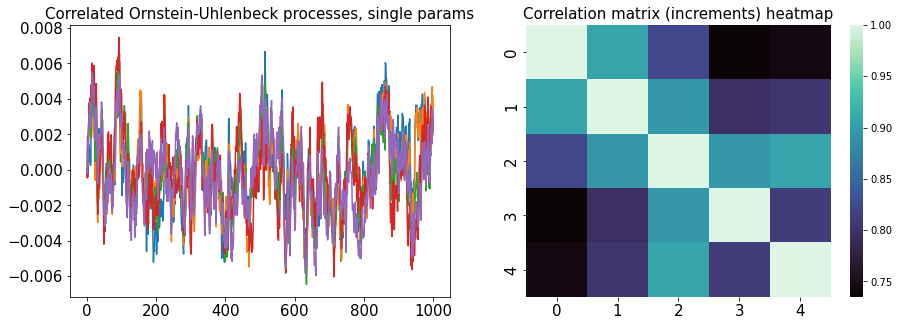

In [22]:
# case 1

T = 1_000
OU_params = OUParams(alpha=0.07, gamma=0.0, beta=0.001)
n_proc = 5
rho = 0.9
OU_procs = get_corr_OU_procs(T, OU_params, n_proc, rho)

#----------------------------------------------------
# plot
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 5))

title = "Correlated Ornstein-Uhlenbeck processes, single params"
plt.subplot(1, 2, 1)
plt.plot(OU_procs)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Correlation matrix (increments) heatmap"
plt.subplot(1, 2, 2)
sns.heatmap(np.corrcoef(np.diff(OU_procs, axis=0), rowvar=False), cmap="mako")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4')])

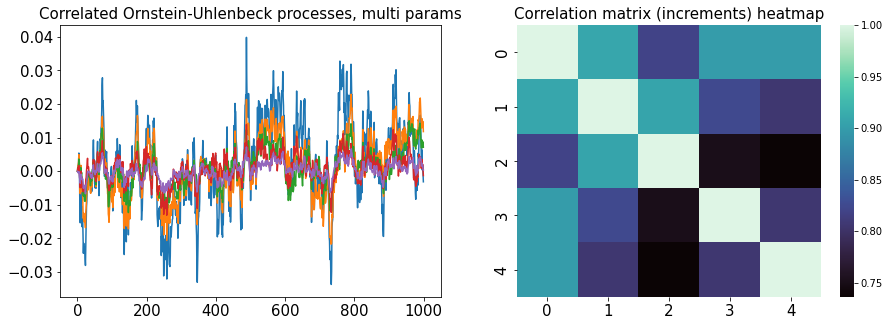

In [23]:
# case 2

T = 1_000
OU_params = (
    OUParams(alpha=0.07, gamma=0.0, beta=0.005),
    OUParams(alpha=0.05, gamma=0.0, beta=0.003),
    OUParams(alpha=0.06, gamma=0.0, beta=0.002),
    OUParams(alpha=0.09, gamma=0.0, beta=0.002),
    OUParams(alpha=0.08, gamma=0.0, beta=0.001),
)
rho = 0.9
OU_procs = get_corr_OU_procs(T, OU_params, n_proc, rho)

#----------------------------------------------------
# plot
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 5))

title = "Correlated Ornstein-Uhlenbeck processes, multi params"
plt.subplot(1, 2, 1)
plt.plot(OU_procs)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Correlation matrix (increments) heatmap"
plt.subplot(1, 2, 2)
sns.heatmap(np.corrcoef(np.diff(OU_procs, axis=0), rowvar=False), cmap="mako")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Conclusion

We have successfully built a mini-library to simulate the Ornstein-Uhlenbeck process and estimate its parameters from data. This is extremely useful for Monte Carlo simulations, once we know the parameters of a process we want to study then we can generate many Monte Carlo trials to get some statistics and further analysis.

Stay tuned for the next story in the series.

# Stochastic Processes Simulation - The Cox-Ingersoll-Ross Process

The Cox-Ingersoll-Ross (CIR) process is another stationary process of great importance. Albeit most of its applications lie in the financial realm, it is an interesting stationary stochastic process in its own right.

It is the simplest particular case of basic affine jump diffusive processes and an ergodic process.

The main characteristic of this process, besides stationarity, is that it is always positive. Hence, making it an attractive stochastic candidate to use as the random term coefficient in a diffusive process.

In this story, we will learn the basics of the CIR process. We will simulate a single CIR process and many correlated processes. We will also learn how to estimate the CIR parameters from data.

We will continuously use references to concepts and code from the first story of the series about Brownian motion. If you already know the basics of Brownian motion, use the code from that story. Otherwise, please read it first and then come back to this story.

## SDE for the process

The SDE (stochastic differential equation) for the CIR process is:

$$ d\sigma_{t} = a(b-\sigma_{t})d_{t} + c \sqrt{\sigma_{t}}dW_{t}$$

where $W_{t}$ is a Brownian motion, a, b and c are positive constants: furthermore, to avoid zero values, the condition $2ab >= c^2$ has to be met. Note that the process $\sigma_{t}$ cannot attain negative values.

Sadly, there is no closed-form solution for this SDE, but we can solve it numerically.

The CIR process is stationary, and it has a positively skewed distribution, with an asymptotic mean b.

The mean-reversion of the process is given by the drift term (dt term), which has the same form as the drift term of the Ornstein-Uhlenbeck process. When σ_t is larger than b, the drift term becomes negative, pulling σ_t back towards b. If σ_t is smaller than b, the opposite happens. a is the mean-reversion parameter, it controls the magnitude of the drift, and hence, higher values will cause a more aggressive mean-reversion.

Finally, c controls the magnitude of the random shocks of the process (dW term). Notice that the squared value of the process itself modulates the random shocks. Therefore, for higher process values, the random shocks are more significant than for smaller values.

## Simulating the process

First, we define the dataclass, which contains the parameters for the process. Passing around many parameters often gets messy; it’s cleaner to pass them in an object of their own. This class will raise an exception (ValueError) upon creation if $2ab < c²$.

In [25]:
from dataclasses import dataclass
from typing import Optional, NoReturn

@dataclass
class CIRParams:
    """CIR process params, 2ab has to be larger or equal then c^2."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float  # Brownian motion scale factor (standard deviation)
    
    def __post_init__(self) -> Optional[NoReturn]:
        if 2 * self.a * self.b < self.c ** 2:
            raise ValueError("2ab has to be less than or equal to c^2.")
        return None

To simulate the process, we need to convert the SDE into a discrete equation (the time series way) using the Euler-Maruyama method. Making $\delta t = 1$ (unit time step):

$$ \sigma_{t} = \sigma_{t-1} + a(b-\sigma_{t-1}) + c\sqrt{\sigma_{t-1}}\Delta W_{t}$$

Then, using the equation, we generate values for the process along its path (for loop). The function “_generate_CIR_process” in the following code does this.

To generate the CIR process simulation, we will use the code about Brownian motion that we developed in the first story of the series. 

In [27]:
from typing import Optional, NoReturn, Any
import numpy as np

def get_CIR_process(
    T: int,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is the sample size.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    dW = get_dW(T, random_state)
    return _generate_CIR_process(dW, CIR_params, sigma_0)


def _generate_CIR_process(
    dW: np.ndarray,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
) -> np.ndarray:
    """
    Generate the CIR process given the Brownian motion.
    - dW is a 1D array with the Brownian motion increments.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    T = len(dW)
    _sigma_0 = _select_sigma_0(sigma_0, CIR_params)
    sigma_t = [_sigma_0]
    for t in range(1, T):
        dsigma_t = (
            CIR_params.a * (CIR_params.b - sigma_t[t - 1])
            + CIR_params.c * np.sqrt(sigma_t[t - 1]) * dW[t]
        )
        # if Nan in simulation raise an error.
        _validate_not_nan(dsigma_t)
        sigma_t.append(sigma_t[t - 1] + dsigma_t)
    return np.asarray(sigma_t)


def _select_sigma_0(
    sigma_0_in: Optional[float], CIR_params: CIRParams
) -> float:
    """Returns sigma_0input if not None, else b (the long term mean)."""
    return sigma_0_in if sigma_0_in is not None else CIR_params.b


def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
    if np.isnan(dsigma_t):
        raise ValueError(
            "CIR process simulation crashed, check your CIR_params. "
            + "Maybe choose a smaller c value."
        )
    return None

Please note that there is the possibility that the process becomes negative along the path, even though the CIR params satisfy $2ab >= c²$. Especially for values close to the inequality. That is because of the discrete step instead of the continuous differential. If this happens, the simulation will raise a ValueError exception at runtime

Simulating the process:

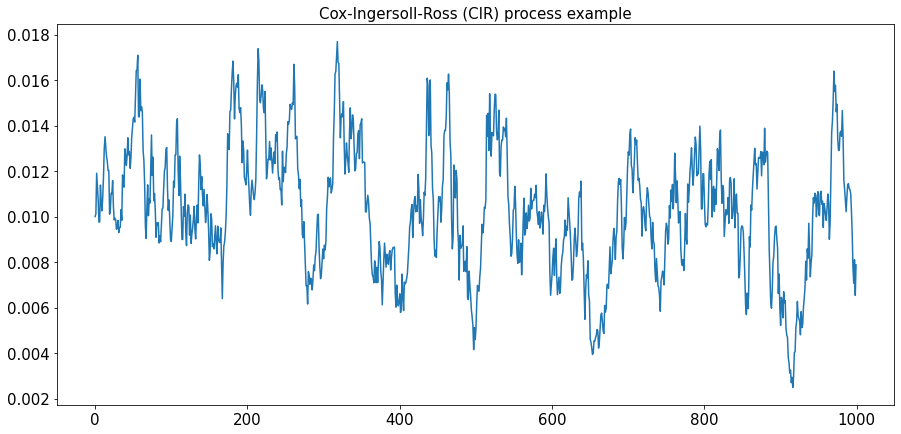

In [28]:
CIR_params = CIRParams(a=0.06, b=0.01, c=0.009)
CIR_proc = get_CIR_process(1_000, CIR_params)

#----------------------------------------------------
# plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))

title = "Cox-Ingersoll-Ross (CIR) process example"
plt.plot(CIR_proc)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## Parameter estimation

To estimate the CIR parameters from a given process we use linear regression with two variables.

Using the Euler-Maruyama method (the random difference Δσ_t is taken as a forward difference, we approximate the stochastic differential equation by a discrete equation:

$$ \Delta \sigma_{t} = a(b-\sigma_{t}) \Delta t  + c\sqrt{\sigma_{t}}\epsilon_{t}$$

Making Δt = 1 and dividing by the square root of σ_t:

$$ \Delta \sigma_{t} / \sqrt{\sigma_{t}} = ab/\sqrt{\sigma_{t}} - a\sqrt{\sigma_{t}} + c\epsilon_{t}$$

where \epsilon es the standard normal. 

Using the variable substitution:

$$\{y = \Delta \sigma_{t} / \sqrt{\sigma_{t}},
    x_{1} = 1 / \sqrt{\sigma_{t}},
    x_{2} = \sqrt{\sigma_{t}} \}$$

we can then write our discrete equation as:

$$ y = a_{1}x_{1} + b_{1}x_{2} + c\epsilon_{t} $$

which now has the form of a linear model with two variables.

The following function performs the regression and estimates the CIR parameters:

In [29]:
import numpy as np
from sklearn.linear_model import LinearRegression


def estimate_CIR_params(sigma_t: np.ndarray) -> CIRParams:
    """
    Estimate CIR params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma_sqrt = np.sqrt(sigma_t[:-1])
    y = np.diff(sigma_t) / sigma_sqrt
    x1 = 1.0 / sigma_sqrt
    x2 = sigma_sqrt
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return CIRParams(a, b, c)

In [30]:
# generate process with random_state to reproduce results
CIR_params = CIRParams(a=0.05, b=0.5, c=0.02)
CIR_proc = get_CIR_process(1_000, CIR_params, random_state=3)

# estimate parameters
CIR_params_hat = estimate_CIR_params(CIR_proc)

print(CIR_params_hat)

CIRParams(a=0.051253247820195046, b=0.504358862242795, c=0.02014670637207867)


We get:

CIRParams(a=0.05125324782019516, b=0.5043588622427937, c=0.02014670637207867)

which is very close to the input parameters.

## Correlated processes

If we can simulate one process, why not simulate many. If we are going to simulate many CIR processes, we naturally want the choice of making them pairwise correlated.

In the first part of the series, we coded a matrix of correlated Brownian motions; we will use these processes to build correlated CIR processes. Correlation of diffusive processes (Itô processes) happens when the random terms are correlated.

Let’s code a function to get correlated CIR processes. The two main functionalities that we want:

- CIR parameters are shared by all processes, processes can be correlated.
- Each process has its own CIR parameters, processes can be correlated.

We let the “CIR_params” argument take two different types to achieve this. Case 1) above is reproduced by letting “CIR_params” be an instance of “CIRParams”; case 2) is reproduced by letting “CIR_params” be a tuple of instances of “CIRParams”.

In [31]:
from typing import Optional, Union, Tuple

def get_corr_CIR_procs(
    T: int,
    CIR_params: Union[CIRParams, Tuple[CIRParams, ...]],
    n_procs: Optional[int] = None,
    rho: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    Simulate correlated CIR processes, correlation (rho) can be 0 or None.
    - T is the sample size of the processes.
    - CIR_params can be a an instance of CIRParams, in that case
        all processes have the same parameters. It can also be a tuple,
        in that case each process will have the parameters in the tuple,
        each column in the resulting 2D array corresponds to the tuple index.
    - n_procs is ignored if CIR_params is tuple, else, corresponds to the number
        of processes desired. If CIR_params is not tuple and n_procs is None, will
        raise ValueError.
    - rho is the correlation coefficient.
    - random_state to reproduce results.
    """
    _n_procs = _get_n_procs(CIR_params, n_procs)
    corr_dWs = get_corr_dW_matrix(
        T, _n_procs, rho, random_state=random_state
    )
    is_CIR_params_tpl = _is_CIR_params_tuple(CIR_params)
    CIR_procs = []
    for i in range(_n_procs):
        CIR_params_i = _get_CIR_params_i(CIR_params, i, is_CIR_params_tpl)
        dW_i = corr_dWs[:, i]
        CIR_procs.append(_get_CIR_process_i(CIR_params_i, dW_i))
    return np.asarray(CIR_procs).T


def _is_CIR_params_tuple(
    CIR_params: Union[CIRParams, Tuple[CIRParams, ...]]
) -> bool:
    """
    Check is CIR_params is a tuple of params,
    return bool.
    """
    return isinstance(CIR_params, tuple)


def _get_n_procs(
    CIR_params: Union[CIRParams, Tuple[CIRParams, ...]], n_procs: Optional[int]
) -> int:
    """
    Define the number of processes, if CIR_params is a tuple the
    number of processes is the lenght of the tuple. If it is not a tuple
    then it is the "n_procs" supplied as argument,
    if it is None will raise ValueError.
    """
    if _is_CIR_params_tuple(CIR_params):
        return len(CIR_params)  # type: ignore
    elif n_procs is None:
        raise ValueError("If OU_params is not tuple, n_procs cannot be None.")
    return n_procs


def _get_CIR_params_i(
    CIR_params: Union[CIRParams, Tuple[CIRParams, ...]],
    i: int,
    is_CIR_params_tpl: bool,
) -> CIRParams:
    """
    Returns the ith value of the CIR_params tuple if it is a tuple,
    otherwise returns CIRParams.
    """
    if is_CIR_params_tpl:
        return CIR_params[i]  # type: ignore
    return CIR_params  # type: ignore


def _get_CIR_process_i(CIR_params: CIRParams, dW: np.ndarray) -> np.ndarray:
    """
    Simulates the CIR process with an external dW.
    sigma_0 is taken as the asymptotic mean b for simplicity.
    """
    return _generate_CIR_process(dW, CIR_params)

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4')])

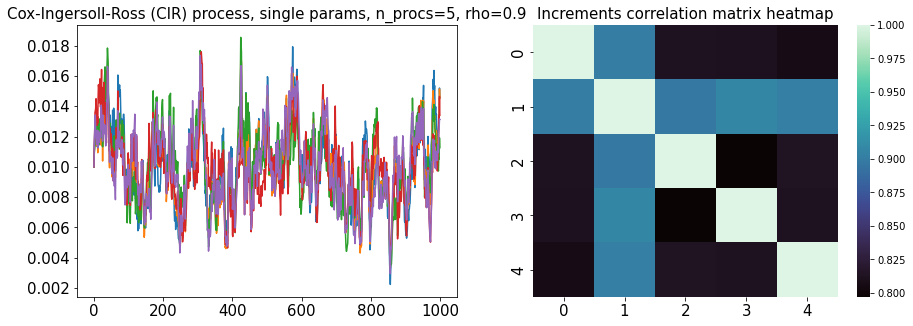

In [32]:
#----------------------------------------------------------------
# single params case

# define the parameters
T = 1_000
CIR_params = CIRParams(a=0.06, b=0.01, c=0.009)
n_procs = 5
rho = 0.9

CIR_procs = get_corr_CIR_procs(T, CIR_params, n_procs, rho)

#----------------------------------------------------------------
# plot
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
title = f"Cox-Ingersoll-Ross (CIR) process, single params, {n_procs=}, {rho=}"
plt.plot(CIR_procs)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1, 2, 2)
title = f"Increments correlation matrix heatmap"
sns.heatmap(np.corrcoef(np.diff(CIR_procs, axis=0), rowvar=False), cmap="mako")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4')])

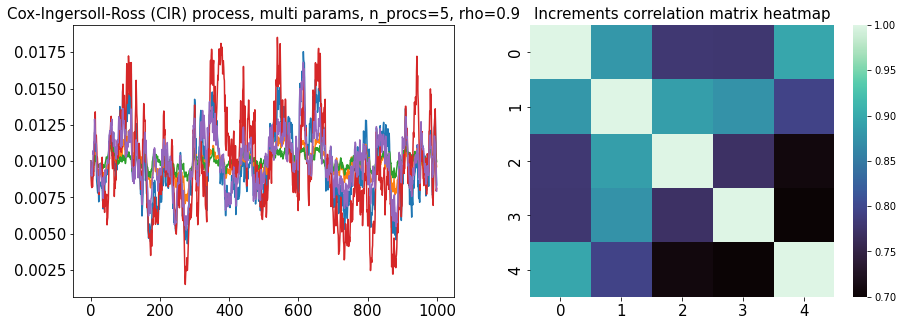

In [33]:
#----------------------------------------------------------------
# multi params case

# define the parameters
T = 1_000
CIR_params = (
    CIRParams(a=0.06, b=0.01, c=0.009),
    CIRParams(a=0.05, b=0.01, c=0.003),
    CIRParams(a=0.08, b=0.01, c=0.002),
    CIRParams(a=0.04, b=0.01, c=0.012),
    CIRParams(a=0.07, b=0.01, c=0.007),
)
rho = 0.9

CIR_procs = get_corr_CIR_procs(T, CIR_params, n_procs, rho)

#----------------------------------------------------------------
# plot
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
title = f"Cox-Ingersoll-Ross (CIR) process, multi params, {n_procs=}, {rho=}"
plt.plot(CIR_procs)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1, 2, 2)
title = f"Increments correlation matrix heatmap"
sns.heatmap(np.corrcoef(np.diff(CIR_procs, axis=0), rowvar=False), cmap="mako")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Stochastic Processes Simulation - Geometric Brownian Motion

Geometric Brownian motion is perhaps the most famous stochastic process aside from Brownian motion itself. It arises when we consider a process whose increments’ variance is proportional to the value of the process.

In this story, we will discuss geometric (exponential) Brownian motion. We will learn how to simulate such a process and estimate the necessary parameters, for a simulation, from data. Our concrete goal will be to simulate many, possibly correlated, geometric Brownian motions.

## The equation for the process

The SDE (stochastic differential equation) for the process is:

$$ dP_{t} / P_{t} = \mu d_{t} + \sigma dW_{t} $$

where $W-{t}$ is a Brownian motion. In other words, the quotient of the differential and the process itself follows a diffusive process.

Using the elementary stochastic calculus we can easily integrate the SDEW in closed-form:

$$ P_{t} = P_{0} \exp{(\int_{0}^{t} [\mu - \sigma^2 / 2]ds + \int_{0}^{t} \sigma dW_{s})} $$

This equation considers the possibility that μ and σ are functions of t and W, this is why this equation is known as generalized geometric Brownian motion.

When μ and σ are constant then the equation is much simpler:

$$ P_{t} = P_{0} \exp{([\mu - \sigma^2 / 2]t + \sigma W_{t})} $$

## Code structure and architecture

A priori, we may not know the form of μ and σ. Ok, you got me here; this story is about geometric Brownian motion, so μ and σ should be constant.

But what happens if they are not? What happens if μ and σ could be deterministic functions of time or other stochastic processes?

If we were to code this in a naive function, we would need arguments (two of them) to select the option for μ and σ. Such an approach would make the internal structure of the function very messy, with many cases considered there (suppose there are m choices for building μ and σ, the number of cases would then be m x n). Furthermore, if we were to introduce another function for either μ or σ, we would need to change said function — a recipe for disaster.

We won’t do this. Instead, we will walk down the OO (object-oriented design) path and establish interfaces (abstract) for what μ and σ objects should be. Then we create a generalized Brownian motion object which depends on these abstract interfaces instead of concrete implementations. This way, we would not need to change the generalized Brownian motion object whenever we change μ or σ objects.

At first, this OO approach may seem longer; but remember, the shortest path seems longer. In the end, it will be worth it.

Remember, our goal is to generate many Brownian motions; hence, our interfaces should be able to create many processes simultaneously.

## Constant processes

As I mentioned in the previous section, this story is about geometric Brownian motion; hence, μ and σ are constant. However, achieve the generality we seek through our OO approach. They should be constant processes rather than simple constant numbers. We will create a small object to generate constant processes (a 2D array with T rows where each column is constant). The peculiarity of this array is that the argument which defines the actual constants (“constants”) can be:

- A float, in which case all processes have the same constant, and we need the argument “n_procs” to define the number of processes (columns).
- A tuple of floats, in which case each process has a different constant defined by the tuple. The “n_procs” argument is ignored. The resulting array’s columns are indexed in the same order as the constant tuple.

In [35]:
from typing import Optional, Union, Tuple
import numpy as np

class ConstantProcs:
    """
    Constant drift  matrix, each column of the matrix is a 1D process.
    - T is the sample size (rows of the matrix)
    - constants is either the constant for all processes (non random)
        or a tuple of constants one for each process
    - n_procs is the number of process (columns in the matix),
        if constants is tuple, this argument is ignored,
        if constants is a float then n_procs cannot be None,
        otherwise will raise ValueError
    The returned matrix columns are indexes in the same order as
    the constants tuple (in case it is a tuple).
    """

    def __init__(
        self,
        T: int,
        constants: Union[float, Tuple[float, ...]],
        n_procs: Optional[int] = None,
    ) -> None:
        self.T = T
        self.constants = constants
        self._n_procs = n_procs

        self._n_procs_ = self._get_n_procs()

    @property
    def n_procs(self) -> int:
        """The number of drift processes."""
        return self._n_procs_

    def get_proc(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 2D array, each column is a 1D process,
        the number of rows define the sample size,
        random_state not None to reproduce results.
        """
        if isinstance(self.constants, tuple):
            return (
                np.repeat(self.constants, self.T, axis=0).reshape(-1, self.T).T
            )
        return self.constants * np.ones((self.T, self._n_procs_))

    def _get_n_procs(self) -> int:
        """
        Check what is the correct n_proc, depending on params type and
        n_procs type.
        - if constants is float then n_procs cannot be None,
            the value of n_procs is then passed as the correct one.
        - if constants is tuple n_procs input argument is
            ignored and the correct n_procs is then the size of the tuple.
        """
        if isinstance(self.constants, tuple):
            return len(self.constants)
        elif self._n_procs is None:
            raise ValueError(
                "If constants is not tuple, n_procs cannot be None."
            )
        return self._n_procs

In [36]:
# generate constant processes with the same constant

T = 1_000 # sample size
constants = 1 # one constant for all procs
n_procs = 3 

# instantiate the class
constant_procs = ConstantProcs(T, constants, n_procs)

# proc matrix, each column is one process
constant_procs_mat = constant_procs.get_proc()

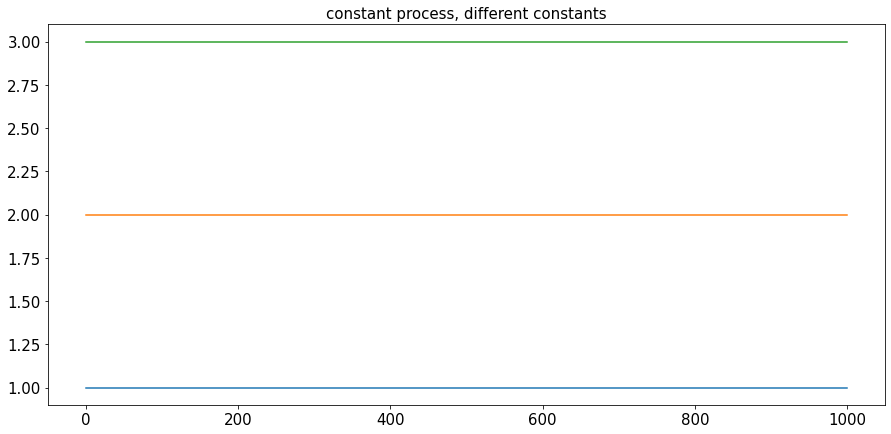

In [37]:
# generate constant processes with different constants

T = 1_000 # sample size
constants = (1.0, 2.0, 3.0) # one constant for all procs 

# instantiate the class
constant_procs = ConstantProcs(T, constants, n_procs)

# proc matrix, each column is one process
constant_procs_mat = constant_procs.get_proc()

#----------------------------------------------------------------
# plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))

title = "constant process, different constants"
plt.plot(constant_procs_mat)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [38]:
# Drift Process

from typing import Protocol, Optional

class Drift(Protocol):
    """
    Base class for drift processes matrix.
    Each column of the drift matrix is a 1D process.
    """

    @property
    def sample_size(self) -> int:
        """The sample size T of the drift processes."""

    @property
    def n_procs(self) -> int:
        """The number of drift processes."""

    def get_mu(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 2D array, each column is a 1D process,
        the number of rows define the sample size.,
        random_state not None to reproduce results.
        """

The drift process, in this case, is constant. So we wrap our “ConstantProcs” object inside the following class, which implements the “Drift” protocol. We inherit from “ConstantProcs” to make the wrapping more explicit and avoid duplicated code.

In [40]:
from typing import Optional, Tuple

class ConstantDrift(ConstantProcs):
    """
    Implements the Drift Protocol.
    Constant drift processes matrix, each column of the drift
    matrix is a 1D process.
    - T is the sample size (rows of the matrix)
    - mu_constants is either the constant for all processes (non random)
        or a tuple of constants one for each process
    - n_procs is the number of process (columns in the matix),
        if mu_constants is tuple, this argument is ignored,
        if mu_constants is a float then n_procs cannot be None,
        otherwise will raise ValueError
    The returned matrix columns are indexes in the same order as
    the mu_constants tuple (in case it is a tuple).
    """

    def __init__(
        self,
        T: int,
        mu_constants: Union[float, Tuple[float, ...]],
        n_procs: Optional[int] = None,
    ) -> None:
        super().__init__(T, mu_constants, n_procs)
        self.mu_constants = mu_constants
        self.T = T
        self._n_procs = n_procs

    @property
    def sample_size(self) -> int:
        """The sample size T of the drift processes."""
        return self.T

    @property
    def n_procs(self) -> int:
        """The number of drift processes."""
        return super().n_procs

    def get_mu(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 2D array, each column is a 1D process,
        the number of rows define the sample size,
        random_state not None to reproduce results.
        """
        return super().get_proc(random_state)

**Sigma process**

This is the interface for the sigma process:

In [41]:
from typing import Protocol, Optional

class Sigma(Protocol):
    """
    Base class for sigma processes matrix.
    Each column of the sigma matrix is a 1D process.
    """

    @property
    def sample_size(self) -> int:
        """The sample size T of the sigma processes."""

    @property
    def n_procs(self) -> int:
        """The number of sigma processes."""

    def get_sigma(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 2D array, each column is a 1D process,
        the number of rows define the sample size.,
        random_state not None to reproduce results.
        """

Which, again, is constant. Utterly analogous to the previous section, we wrap “ConstantProcs” inside a class that complies with the “Sigma” protocol.

In [42]:
from typing import Optional, Tuple

class ConstantSigma(ConstantProcs):
    """
    Implements the Sigma Protocol.
    Constant sigma processes matrix, each column of the drift
    matrix is a 1D process.
    - T is the sample size (rows of the matrix)
    - sigma_constants is either the constant for all processes
        (non random) or a tuple of constants one for each process
    - n_procs is the number of process (columns in the matix),
        if sigma_constants is tuple, this argument is ignored,
        if sigma_constants is a float then n_procs cannot be None,
        otherwise will raise ValueError
    The returned matrix columns are indexes in the same order as
    the mu_constants tuple (in case it is a tuple).
    """

    def __init__(
        self,
        T: int,
        sigma_constants: Union[float, Tuple[float, ...]],
        n_procs: Optional[int] = None,
    ) -> None:
        super().__init__(T, sigma_constants, n_procs)
        self.sigma_constants = sigma_constants
        self.T = T
        self._n_procs = n_procs

    @property
    def sample_size(self) -> int:
        """The sample size T of the sigma processes."""
        return self.T

    @property
    def n_procs(self) -> int:
        """The number of sigma processes."""
        return super().n_procs

    def get_sigma(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 2D array, each column is a 1D process,
        the number of rows define the sample size,
        random_state not None to reproduce results.
        """
        return super().get_proc(random_state)

**Initial values**

Initial values are the values for P_0 as they appear in the geometric Brownian motion equation from the first section of the story. Here is another example where we need an abstract interface (protocol). The strategy for choosing the initial values might change according to our needs. However, this should not change the generalized Brownian motion object. In this case, the protocol does not require a 2D array but rather a 1D array where each vector value corresponds to the initial value (P_0) for each process.

In [43]:
from typing import Protocol, Optional


class InitP(Protocol):
    """
    Base for the vector of initial values for gen geometic
    Brownian motions (P_0).
    """

    @property
    def n_procs(self) -> int:
        """The number of init Ps (P_0's), length of P_0s vector."""

    def get_P_0(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 1D vector, random_state to reproduce
        results in case ther is something random, ignored
        if P_0 generation is non-random.
        """

The first behavior that comes to mind is a random choice. We want to input an interval of values and then get random values uniformly sampled. So we do just that. We implement such logic, making it compliant with the “InitP” protocol:

In [44]:
from typing import Optional, NoReturn

import numpy as np

class RandomInitP:
    """
    Implements InitP.
    Random choice init P_0s.
    lower_bound is strictly less than upper_bound,
    both bounds are strictly positive.
    """

    def __init__(
        self, lower_bound: float, upper_bound: float, n_procs: int
    ) -> None:
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self._n_procs = n_procs

        self._validate_bounds()

    @property
    def n_procs(self) -> int:
        """The number of init Ps (P_0's), length of P_0s vector."""
        return self._n_procs

    def get_P_0(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 1D vector, random_state to reproduce results.
        """
        rng = np.random.default_rng(random_state)
        # random numbers in [0, 1)
        random_vec = rng.random(self._n_procs)
        # rescale [0, 1) interval to bounds
        return (
            self.upper_bound - self.lower_bound
        ) * random_vec + self.lower_bound

    def _validate_bounds(self) -> Optional[NoReturn]:
        """If price bounds are incorrect raise an exception."""
        if self.lower_bound <= 0 or self.upper_bound <= 0:
            raise ValueError("bounds have to be strictly positive ")
        if self.lower_bound >= self.upper_bound:
            raise ValueError("upper bound has to be larger than lower_bound.")
        return None

Another behavior we want is to get P_0s from data. If we input a matrix (2D array with processes indexed as columns), the initial values are taken from it. Either the first values or the last values are used as P_0. So we code that.

In [45]:
from typing import Optional

import numpy as np

class DataInitP:
    """
    Implements InitP.
    P_0s from data.
    - P_data should be a 2D numpy array. Each column is a process.
    - last_P is a boolean flag, if true uses last sampled value from P_mat
        (last row), else, uses first value (first row).
    """

    def __init__(self, P_data: np.ndarray, last_P: bool = True) -> None:
        self.P_data = P_data
        self.last_P = last_P

    @property
    def n_procs(self) -> int:
        """The number of init Ps (P_0's), length of P_0s vector."""
        return self.P_data.shape[1]

    def get_P_0(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 1D vector, random_state to reproduce
        results in case ther is something random, ignored
        if P_0 generation is non-random.
        """
        row_idx = -1 if self.last_P else 0
        return self.P_data[row_idx, :]

In [46]:
# intantiate InitP concrete implementation
lower_bound = 2_000
upper_bound = 10_000
n_procs = 4
random_init_P = RandomInitP(lower_bound, upper_bound, n_procs)

P_0s = random_init_P.get_P_0() # 1D vec

**The simulation, putting the pieces together**

At last, we come to coding the geometric Brownian motion, and you guessed it correctly, we will build a class for it. This class will depend on abstractions for μ (Drift protocol), σ (Sigma protocol), and P_0 (InitP protocol). It will also depend on ρ, the correlation coefficient for the processes.

In [48]:
from typing import Optional, NoReturn
import numpy as np

class GenGeoBrownian:
    """
    Generalized Geometric Brownian motion simulator.
    Generates a matrix (2D numpy array) of processes, 
    each column is a process.
    - drift is an concrete implementation of the Drift protocol
    - sigma is a concrete implementation of the Sigma protocol
    - init_P is a concrete implementation of the InitP protocol
    - rho is the correlation coefficient for the gen geo Brownian
        motion processes matrix,
    """
    def __init__(
        self,
        drift: Drift,
        sigma: Sigma,
        init_P: InitP,
        rho: Optional[float] = None,
    ) -> None:
        self.drift = drift
        self.sigma = sigma
        self.init_P = init_P
        self.rho = rho

        self._validate_drift_sigma_init_P()
        self.T, self.n_procs = self.drift.sample_size, self.drift.n_procs

    def get_P(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 2D array, each column is a process,
        random_state not None to reproduce results.
        """
        sigmas = self.sigma.get_sigma(random_state)
        time_integrals = self._get_time_integrals(sigmas, random_state)
        W_integrals = self._get_W_integrals(sigmas, random_state)
        P_0s = self.init_P.get_P_0(random_state)
        return P_0s[None, :] * np.exp(time_integrals + W_integrals)

    def _get_time_integrals(
        self, sigmas: np.ndarray, random_state: Optional[int]
    ) -> np.ndarray:
        """The integral with respect to time."""
        mus = self.drift.get_mu(random_state)
        integrals = np.cumsum(mus - sigmas**2 / 2, axis=0)
        return np.insert(integrals, 0, np.zeros(mus.shape[1]), axis=0)[:-1]

    def _get_W_integrals(
        self, sigmas: np.ndarray, random_state: Optional[int]
    ) -> np.ndarray:
        """Integral with respect to the Brownian motion (W)."""
        dWs = get_corr_dW_matrix(
            self.T, self.n_procs, self.rho, random_state
        )
        integrals = np.cumsum(sigmas * dWs, axis=0)
        return np.insert(integrals, 0, np.zeros(dWs.shape[1]), axis=0)[:-1]

    def _validate_drift_sigma_init_P(self) -> Optional[NoReturn]:
        if (
            self.drift.n_procs != self.sigma.n_procs
            or self.drift.n_procs != self.init_P.n_procs
        ):
            raise ValueError(
                "n_procs for both drift, sigma and init_P has to be the same!"
            )
        elif self.drift.sample_size != self.sigma.sample_size:
            raise ValueError(
                "sample size T for both drift and sigma has to be the same!"
            )
        return None

This is an example of how we build the objects for μ, σ, and P_0 and then inject them to “GenGeoBrownian”:

In [49]:
# constant drift instance
T = 1_000
mu_constants = (0.00014, 0.00012, -0.0002, -0.00007)

constant_drift = ConstantDrift(T, mu_constants)

# constant sigma instance
T = 1_000
sigma_constants = (0.01, 0.02, 0.015, 0.025)

constant_sigma = ConstantSigma(T, sigma_constants)

# init P instance
lower_bound = 3_000
upper_bound = 10_000
n_procs = 4
random_init_P = RandomInitP(lower_bound, upper_bound, n_procs)

# generalized geometric Brownian motion with dependency injection
rho = 0.8
gen_geo_brownian = GenGeoBrownian(constant_drift, constant_sigma, random_init_P, rho=rho)

# generate matix of P processes
P_mat = gen_geo_brownian.get_P(random_state=3)

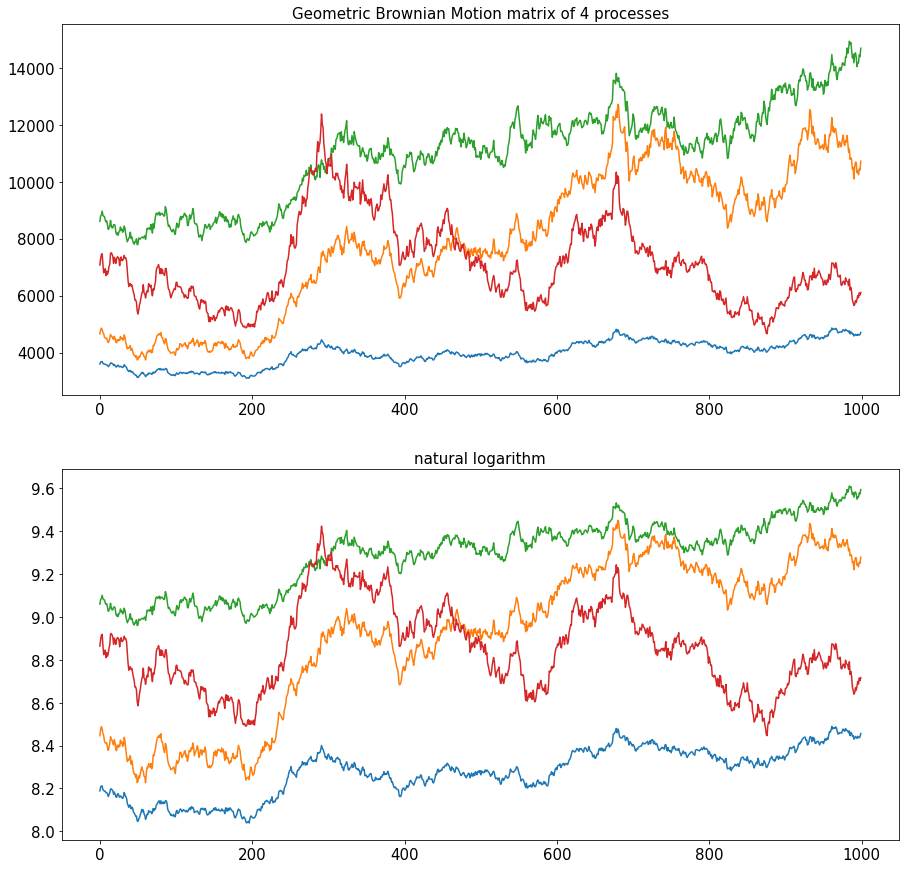

In [50]:
#----------------------------------------------------------------
# plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15, 15))


title = f"Geometric Brownian Motion matrix of {P_mat.shape[1]} processes"
plt.subplot(2, 1, 1)
plt.plot(P_mat)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = f"natural logarithm"
plt.subplot(2, 1, 2)
plt.plot(np.log(P_mat))
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

**Estimate constant parameters from data**

We’ve simulated geometric Brownian processes, and now it is time to estimate μ and σ from data.

We know that the diffusion increments are normally distributed with mean μ and variance σ². Using the Euler-Maruyama method for discrete approximation (forward differences for the stochastic differentials) and making Δt = 1:

$$ \Delta P_{t} / P_{t} = \mu + \sigma \Delta W_{t} $$

We estimate tuples of constants from a matrix of processes (“proc_mat”), as the input for “ConstantDrift” and “ConstantSigma” objects is a tuple:

In [52]:
import numpy as np
from typing import Tuple


def estimate_drift_constants(proc_mat: np.ndarray) -> Tuple[float, ...]:
    """
    Estimate drift constants from data (geometric Brownian motion paths).
    - proc_mat is a 2D array,  each column is a process
    Returns a tuple of floats indexed with the same order as proc_mat
    columns.
    """
    diffusion_increments = np.diff(proc_mat, axis=0) / proc_mat[:-1, :]
    increment_mus = np.mean(diffusion_increments, axis=0)
    return tuple(float(mu) for mu in increment_mus)


def estimate_sigma_constants(proc_mat: np.ndarray) -> Tuple[float, ...]:
    """
    Estimate sigma constants from data (geometric Brownian motion paths).
    - proc_mat is a 2D array,  each column is a process
    Returns a tuple of floats indexed with the same order as proc_mat
    columns.
    """
    diffusion_increments = np.diff(proc_mat, axis=0) / proc_mat[:-1, :]
    increment_sigmas = np.std(diffusion_increments, axis=0)
    return tuple(float(sigma) for sigma in increment_sigmas)

In [53]:
# estimate drift and sigma constants
drift_constants = estimate_drift_constants(P_mat)

sigma_constants = estimate_sigma_constants(P_mat)

**Estimate correlation from data**

To estimate the correlation, we require for the simulation (a single ρ number) we calculate the correlation matrix (pairwise correlation) for the diffusion increments and then take the average of all the entries excluding the diagonal (which invariably contains 1s).

In [54]:

import numpy as np

def estimate_gBrownian_correlation(proc_mat: np.ndarray) -> float:
    """
    Estimate geometric Brownian motion mean correlation from data.
    - proc_mat is a 2D array,  each column is a process
    Returns a float, the correlation coefficient.
    """
    diffusion_increments = np.diff(proc_mat, axis=0) / proc_mat[:-1, :]
    corr_mat = np.corrcoef(diffusion_increments, rowvar=False)
    # put nan in correlation matrix diagonal to exclude it
    # when taking the mean (nanmean)
    np.fill_diagonal(corr_mat, np.nan)
    return float(np.nanmean(corr_mat))

In [55]:
# estimate rho
rho_estimated = estimate_gBrownian_correlation(P_mat)

## Simulation from data

Finally, an example of usage for the tools we’ve just developed in a real example. So far, we’ve used only NumPy arrays throughout the code. In practice, we probably would get the processes’ data in a pandas DataFrame. The following snippet shows how to perform the necessary estimations and create the object instances:

In [56]:
import pandas as pd

# real data sim
df_P = pd.DataFrame(gen_geo_brownian.get_P(random_state=6))

#----------------------------------------------------------------

# sample size for gen geo Brownian simulation
T = 1_000

# estimate constant drift
mu_constants = estimate_drift_constants(df_P.values)
# implementation of Drift protocol
constant_drift = ConstantDrift(T, mu_constants)

# estimate constant sigma
sigma_constants = estimate_sigma_constants(df_P.values)
# implementation of sigma Protocol
constant_sigma = ConstantSigma(T, sigma_constants)

# init P from data
data_init_P = DataInitP(df_P.values)

# estimate gen geo Brownian correlation
rho = estimate_gBrownian_correlation(df_P.values)

# generalized geometric Brownian motion with dependency injection
gen_geo_brownian = GenGeoBrownian(constant_drift, constant_sigma, data_init_P, rho=rho)

In [57]:
# simulate, random_state not None to reproduce results
gen_geo_brownian.get_P(random_state=None)

array([[6833.28192732, 3142.90662231, 5193.45788652, 3848.41812172],
       [6768.01984631, 3066.24430686, 5176.48775604, 3781.32047368],
       [6646.61238894, 2995.69132178, 5062.30393686, 3788.51050321],
       ...,
       [6119.15668083, 1496.26574376, 3568.98291186, 4821.87675886],
       [5984.85785483, 1453.82436414, 3471.2426386 , 4804.19372814],
       [5935.83671471, 1431.71188355, 3454.57695052, 4873.95055749]])

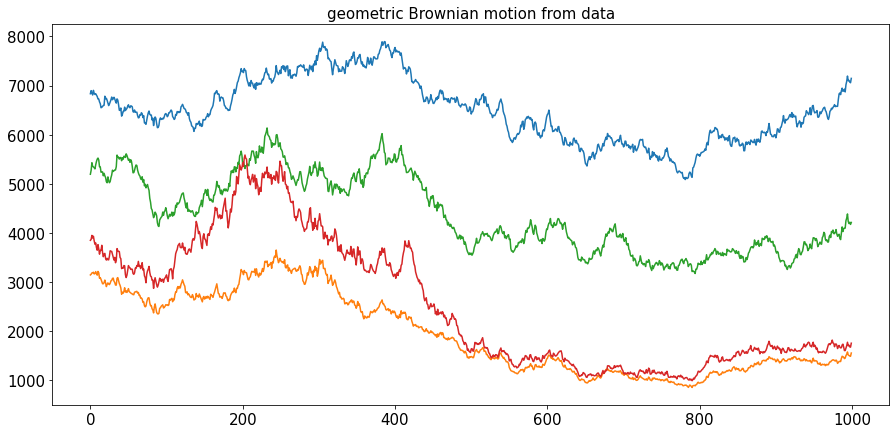

In [58]:
#----------------------------------------------------------------
# plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))

title = f"geometric Brownian motion from data"
plt.plot(gen_geo_brownian.get_P())
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

# Stochastic Processes Simulation — Generalized Geometric Brownian Motion

Alas, we come to the end of our journey through the Stochastic Processes Simulation series. But we saved the best for last. In this story, we will explore generalized geometric Brownian motion.

Generalized geometric Brownian motion occurs when the quotient of the process differential, and the process itself follows an Itô diffusive process. Geometric Brownian motion is a particular case since we make the drift and random coefficients constant.

In the present story, we will use the Ornstein-Uhlenbeck process to model the drift and the Cox-Ingersoll-Ross process to model the random coefficient.

## Integrated SDE

The integrated version of the SDE (stochastic differential equation) for generalized Brownian motion is:

$$ P_{t} = P_{0} \exp{(\int_{0}^{t} [\mu - \sigma^2 / 2]ds + \int_{0}^{t} \sigma dW_{s})} $$

In the previous story, we considered μ and σ as constants. Now we are going to treat them as stochastic processes. Note that μ could be any stochastic process or deterministic function, and σ as well, as long as it is positive.

A suitable candidate for μ is the Ornstein-Uhlenbeck process.

The canonical candidate for σ is the Cox-Ingersoll-Ross process.

### Ornstein-Uhlenbeck drift

In most practical examples, the drift term (μ) of the generalized geometric Brownian motion is close to zero or at least is much less significant than the random term of the process. More often than not, μ alternates its sign (it is mean-reverting); otherwise, the generalized geometric Brownian motion would be somewhat predictable (up to an uncertainty).

A mean-reverting (stationary) process and no positivity constraints? We immediately turn to the canonical process for mean-reversion, the Ornstein-Uhenbeck (OU) process.

In [59]:
from typing import Protocol, Optional

class Drift(Protocol):
    """
    Base class for drift processes matrix.
    Each column of the drift matrix is a 1D process.
    """

    @property
    def sample_size(self) -> int:
        """The sample size T of the drift processes."""

    @property
    def n_procs(self) -> int:
        """The number of drift processes."""

    def get_mu(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 2D array, each column is a 1D process,
        the number of rows define the sample size.,
        random_state not None to reproduce results.
        """

We only need to wrap our OU process code in a class that implements the “Drift” protocol, and we are golden.

In [61]:
from typing import Optional, Union, Tuple
import numpy as np


class OUDrift:
    """
    Implements the geometric_brownian.Drift Protocol.
    Ornstein-Uhlenbeck drift processes matrix, each column of the
    drift matrix is 1D a process.
    - T is the sample size of the processes.
    - OU_params can be a an instance of OU_proc.OUParams, in that case
        all processes have the same parameters. It can also be a tuple,
        in that case each process will have the parameters in the tuple,
        each column in the resulting 2D array corresponds to the tuple index.
    - n_procs is ignored if OU_proc.OU_params is tuple, else, corresponds to
        the number of processes desired. If OU_params is not tuple and
        n_procs is None, will raise ValueError.
    - rho is the correlation coefficient.
    """

    def __init__(
        self,
        T: int,
        OU_params: Union[OUParams, Tuple[OUParams, ...]],
        n_procs: Optional[int] = None,
        rho: Optional[float] = None,
    ) -> None:
        self.T = T
        self.OU_params = OU_params
        self._n_procs = n_procs
        self.rho = rho

        self._n_procs_ = self._get_n_procs()

    @property
    def sample_size(self) -> int:
        """The sample size T of the drift processes."""
        return self.T

    @property
    def n_procs(self) -> int:
        """The number of drift processes."""
        return self._n_procs_

    def get_mu(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 2D array, each column is a 1D process,
        the number of rows define the sample size,
        random_state not None to reproduce results.
        """
        return get_corr_OU_procs(
            self.T, self.OU_params, self._n_procs_, self.rho, random_state
        )

    def _get_n_procs(self) -> int:
        """
        Check what is the correct n_proc, depening on params type and
        n_procs type.
        - if params is instance of OU_proc.OUParams then n_procs cannot be None,
            the value of n_procs is then passed as the correct one.
        - if params is tuple of OU_proc.OUParams n_procs input argument is
            ignored and the correct n_procs is then the size of the tuple.
        """
        if isinstance(self.OU_params, tuple):
            return len(self.OU_params)
        elif self._n_procs is None:
            raise ValueError(
                "If OU_params is not tuple, n_procs cannot be None."
            )
        return self._n_procs

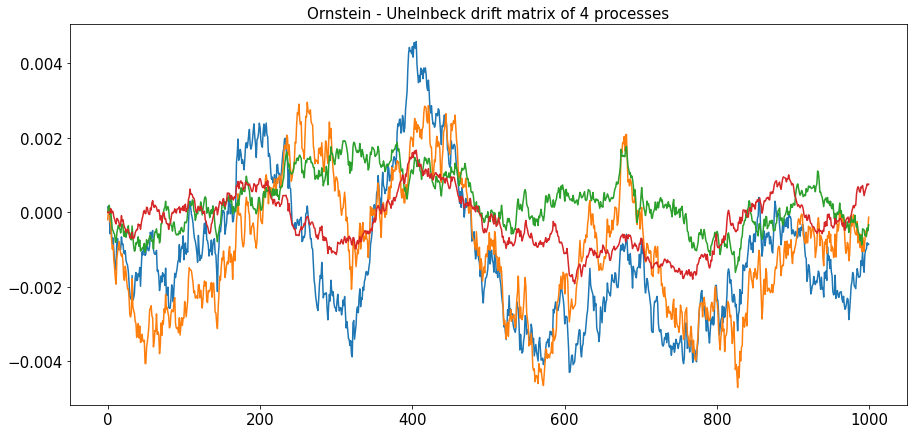

In [62]:
T = 1_000 # sample size 

OU_params = (
    OUParams(alpha=0.0097, gamma=0.00014, beta=0.00028),
    OUParams(alpha=0.008, gamma=-0.0002, beta=0.0003), 
    OUParams(alpha=0.013, gamma=0.0, beta=0.00015),
    OUParams(alpha=0.007, gamma=0.0, beta=0.0001),
)
rho = 0.7 # correation of processes 

# instance of protocol implementation
OU_drift = OUDrift(T, OU_params, rho=rho) 

# processes matrix
drift_mat = OU_drift.get_mu(random_state=2)

#----------------------------------------------------------------
# plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))

title = f"Ornstein - Uhelnbeck drift matrix of {len(OU_params)} processes"
plt.plot(drift_mat)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## Cox-Ingersoll-Ross σ

The σ process also shows mean-reversion in most real-world examples. Furthermore, we know that by construction, it has to be positive. Another feature observed from the σ process is that the random shocks are more influential for larger process values than smaller ones.

Enter the Cox-Ingersoll-Ross process. This process ticks all the boxes for the σ process.

In [63]:
from typing import Protocol, Optional


class Sigma(Protocol):
    """
    Base class for sigma processes matrix.
    Each column of the sigma matrix is a 1D process.
    """

    @property
    def sample_size(self) -> int:
        """The sample size T of the sigma processes."""

    @property
    def n_procs(self) -> int:
        """The number of sigma processes."""

    def get_sigma(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 2D array, each column is a 1D process,
        the number of rows define the sample size.,
        random_state not None to reproduce results.
        """

In [64]:
from typing import Optional, Union, Tuple
import numpy as np

class CIRSigma:
    """
    Implements the geometric_brownian.Sigma Protocol.
    Cox-Ingersoll-Ross sigma processes matrix, each column of the
    drift matrix is 1D a process.
    - T is the sample size of the processes.
    - CIR_params can be a an instance of CIR_proc.CIRParams, in that case
        all processes have the same parameters. It can also be a tuple,
        in that case each process will have the parameters in the tuple,
        each column in the resulting 2D array corresponds to the tuple index.
    - n_procs is ignored if CIR_proc.CIR_params is tuple, else, corresponds to
        the number of processes desired. If CIR_params is not tuple and
        n_procs is None, will raise ValueError.
    - rho is the correlation coefficient.
    """

    def __init__(
        self,
        T: int,
        CIR_params: Union[CIRParams, Tuple[CIRParams, ...]],
        n_procs: Optional[int] = None,
        rho: Optional[float] = None,
    ) -> None:
        self.T = T
        self.CIR_params = CIR_params
        self._n_procs = n_procs
        self.rho = rho

        self._n_procs_ = self._get_n_procs()

    @property
    def sample_size(self) -> int:
        """The sample size T of the drift processes."""
        return self.T

    @property
    def n_procs(self) -> int:
        """The number of drift processes."""
        return self._n_procs_

    def get_sigma(self, random_state: Optional[int] = None) -> np.ndarray:
        """
        Returns a 2D array, each column is a 1D process,
        the number of rows define the sample size,
        random_state not None to reproduce results.
        """
        return get_corr_CIR_procs(
            self.T, self.CIR_params, self._n_procs_, self.rho, random_state
        )

    def _get_n_procs(self) -> int:
        """
        Check what is the correct n_proc, depening on params type and
        n_procs type.
        - if params is instance of OU_proc.OUParams then n_procs cannot be None,
            the value of n_procs is then passed as the correct one.
        - if params is tuple of OU_proc.OUParams n_procs input argument is
            ignored and the correct n_procs is then the size of the tuple.
        """
        if isinstance(self.CIR_params, tuple):
            return len(self.CIR_params)
        elif self._n_procs is None:
            raise ValueError(
                "If CIR_params is not tuple, n_procs cannot be None."
            )
        return self._n_procs

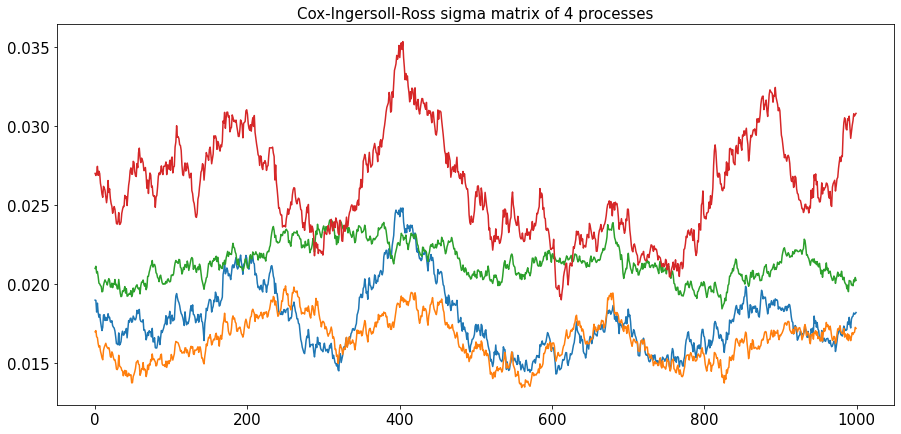

In [65]:
# different parameters for each process.

T = 1_000 # sample size 

CIR_params = (
    CIRParams(a=0.012, b=0.019, c=0.0025),
    CIRParams(a=0.013, b=0.017, c=0.0021), 
    CIRParams(a=0.015, b=0.021, c=0.0017),
    CIRParams(a=0.01, b=0.027, c=0.0029),
)
rho = 0.7 # correation of processes 

# instance of protocol implementation
CIR_sigma = CIRSigma(T, CIR_params, rho=rho)

# processes matrix
sigma_mat = CIR_sigma.get_sigma(random_state=2)

#----------------------------------------------------------------
# plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))

title = f"Cox-Ingersoll-Ross sigma matrix of {len(CIR_params)} processes"
plt.plot(sigma_mat)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## Simulating the process

In this section, we will use the code for geometric Brownian motion developed in the previous story of the series. Such code was designed to depend on abstractions (protocols). So as long as we inject protocol-compliant objects, the code should work without any mods. At this point is when the OO approach pays off (fingers crossed).

Save the code from the previous story as “geometric_brownian.py” and place it in the same directory where you intend to run this story’s code. The main simulator object is named “GenGeoBrownian.” We will use it to generate the following simulations.

To simulate the generalized geometric Brownian motion, we need:

- a “Drift” protocol (“OUDrift”) instance
- a “Sigma” protocol (“CIRSigma”) instance
- an "InitP" protocol instances

In [66]:
# OU drift instance
T = 1_000
OU_params = (
    OUParams(alpha=0.0097, gamma=0.00014, beta=0.00028),
    OUParams(alpha=0.008, gamma=-0.0002, beta=0.0003), 
    OUParams(alpha=0.013, gamma=0.0, beta=0.00015),
    OUParams(alpha=0.007, gamma=0.0, beta=0.0001),
)
OU_rho = 0.6

OU_drift = OUDrift(T, OU_params, rho=OU_rho)

# CIR sigma instance
T = 1_000
CIR_params = (
    CIRParams(a=0.012, b=0.019, c=0.0025),
    CIRParams(a=0.013, b=0.017, c=0.0021), 
    CIRParams(a=0.015, b=0.021, c=0.0017),
    CIRParams(a=0.01, b=0.027, c=0.0029),
)
CIR_rho = 0.7

CIR_sigma = CIRSigma(T, CIR_params, rho=CIR_rho)

# initP instance (random)
lower_bound = 3_000
upper_bound = 10_000
n_procs = 4
random_init_P = RandomInitP(
    lower_bound, upper_bound, n_procs
)

# generalized geometric Brownian motion with dependency injection
rho = 0.8
gen_geo_brownian = GenGeoBrownian(
    OU_drift, CIR_sigma, random_init_P, rho=rho
)

# generate matix of P processes
P_mat = gen_geo_brownian.get_P(random_state=6)

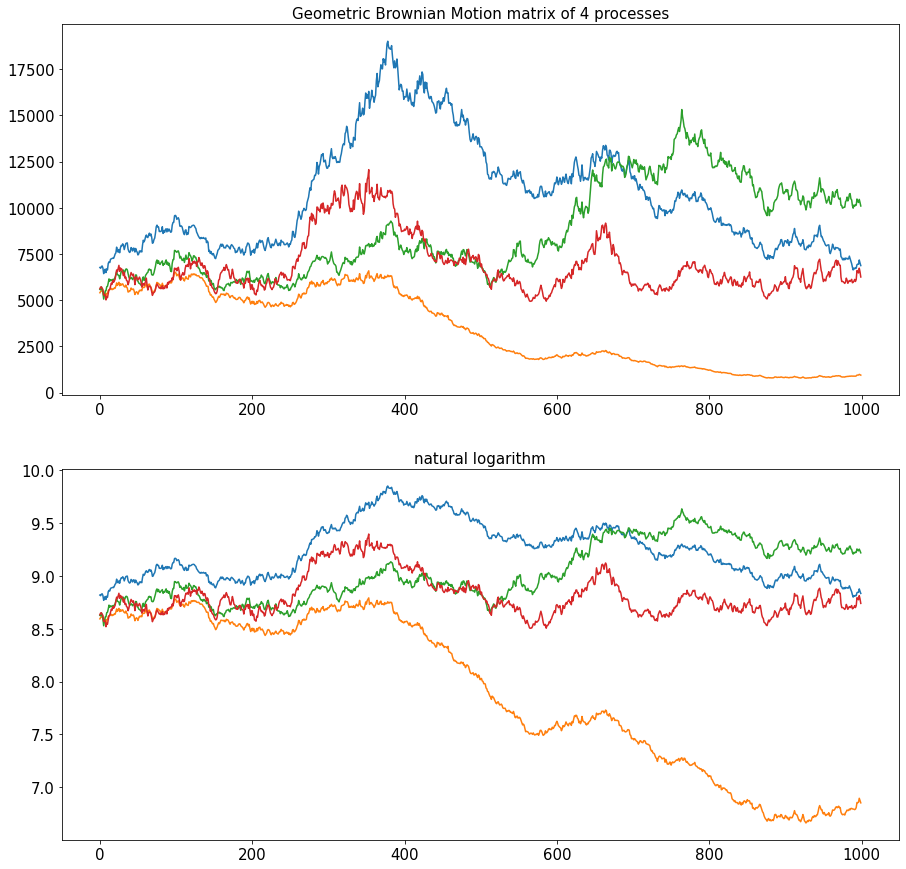

In [67]:
#----------------------------------------------------------------
# plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15, 15))


title = f"Geometric Brownian Motion matrix of {P_mat.shape[1]} processes"
plt.subplot(2, 1, 1)
plt.plot(P_mat)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = f"natural logarithm"
plt.subplot(2, 1, 2)
plt.plot(np.log(P_mat))
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## Parameter estimation from data

Isolating stochastic processes contained in another stochastic process is tricky. But that is what we need to do to estimate the parameters for the OU μ and CIR σ.

The estimation is carried out using a rolling window on the primary process (generalized geometric Brownian motion). The rolling mean will generate the μ process, and the rolling standard deviation will generate the σ process.

We estimate the OU parameters and mean correlation for the μ processes; the “rolling_window” argument is the size of the window:

In [69]:
import numpy as np
from typing import Tuple


def estimate_drift_OU_params(
    proc_mat: np.ndarray, rolling_window: int
) -> Tuple[OUParams, ...]:
    """
    Estimate drift OU_proc.OUParams from data
    (gneralized geometric Brownian motion paths).
    Rolls the the diffusion increments to generate new processes
    for each mu. Then estimate its OU_proc.OUParams
    - proc_mat is a 2D array,  each column is a process
    - rolling window defines the lenght of the window to calculate
        the mean of the increments.
    Returns a tuple of OU_proc.OUParams indexed with the same order as proc_mat
    columns.
    """
    diffusion_increments = np.diff(proc_mat, axis=0) / proc_mat[:-1, :]
    rolled_increments = np.lib.stride_tricks.sliding_window_view(
        diffusion_increments, rolling_window, axis=0
    )
    rolling_mus = np.mean(rolled_increments, axis=-1)
    return tuple(
            estimate_OU_params(rolling_mus[:, i])
            for i in range(rolling_mus.shape[1])
    )


def estimate_drift_correlation(
    proc_mat: np.ndarray, rolling_window: int
) -> float:
    """
    Estimate drift processes mean correlation from data
    (geometric Brownian motion paths).
    - proc_mat is a 2D array,  each column is a process
    - rolling window defines the lenght of the window to calculate
        the mean of the increments.
    Returns a float, the correlation coefficient.
    """
    diffusion_increments = np.diff(proc_mat, axis=0) / proc_mat[:-1, :]
    rolled_increments = np.lib.stride_tricks.sliding_window_view(
        diffusion_increments, rolling_window, axis=0
    )
    rolling_mus = np.mean(rolled_increments, axis=-1)
    corr_mat = np.corrcoef(rolling_mus, rowvar=False)
    # put nan in correlation matrix diagonal to exclude it
    # when taking the mean (nanmean)
    np.fill_diagonal(corr_mat, np.nan)
    return float(np.nanmean(corr_mat))

In [70]:
OU_drift_params = estimate_drift_OU_params(P_mat, rolling_window=100)

drift_correlation = estimate_drift_correlation(P_mat, rolling_window=100)

In [71]:
print(OU_drift_params), print(drift_correlation)

(OUParams(alpha=0.005704730435246729, gamma=-0.0008746304780980676, beta=0.00025655071819423651168), OUParams(alpha=0.0035464721301900716, gamma=-0.002089338562447219, beta=0.00022420098338004194892), OUParams(alpha=0.01093468358427669, gamma=0.00037207058913490466, beta=0.0002942230228551147234), OUParams(alpha=0.01004384125788237, gamma=0.00029109530725183303, beta=0.00037803354457982631524))
0.6721359055474915


(None, None)

And the CIR parameters and mean correlation for the σ processes:

In [74]:
import numpy as np


def estimate_sigma_CIR_params(
    proc_mat: np.ndarray, rolling_window: int
) -> Tuple[CIRParams, ...]:
    """
    Estimate drift CIR_proc.CIRParams from data
    (gneralized geometric Brownian motion paths).
    Rolls the the diffusion increments to generate new processes
    for each mu. Then estimate its CIR_proc.CIRParams
    - proc_mat is a 2D array,  each column is a process
    - rolling window defines the lenght of the window to calculate
        the std of the increments.
    Returns a tuple of CIR_proc.CIRParams indexed with the same order as proc_mat
    columns.
    """
    diffusion_increments = np.diff(proc_mat, axis=0) / proc_mat[:-1, :]
    rolled_increments = np.lib.stride_tricks.sliding_window_view(
        diffusion_increments, rolling_window, axis=0
    )
    rolling_sigmas = np.std(rolled_increments, axis=-1)
    return tuple(
            estimate_CIR_params(rolling_sigmas[:, i])
            for i in range(rolling_sigmas.shape[1])
    )


def estimate_sigma_correlation(
    proc_mat: np.ndarray, rolling_window: int
) -> float:
    """
    Estimate sigma processes mean correlation from data
    (geometric Brownian motion paths).
    - proc_mat is a 2D array,  each column is a process
    - rolling window defines the lenght of the window to calculate
        the std of the increments.
    Returns a float, the correlation coefficient.
    """
    diffusion_increments = np.diff(proc_mat, axis=0) / proc_mat[:-1, :]
    rolled_increments = np.lib.stride_tricks.sliding_window_view(
        diffusion_increments, rolling_window, axis=0
    )
    rolling_sigmas = np.std(rolled_increments, axis=-1)
    corr_mat = np.corrcoef(rolling_sigmas, rowvar=False)
    # put nan in correlation matrix diagonal to exclude it
    # when taking the mean (nanmean)
    np.fill_diagonal(corr_mat, np.nan)
    return float(np.nanmean(corr_mat))

In [75]:
CIR_sigma_params = estimate_sigma_CIR_params(P_mat, rolling_window=100)

sigma_correlation = estimate_sigma_correlation(P_mat, rolling_window=100)

print(CIR_sigma_params), print(sigma_correlation)

(CIRParams(a=0.004305664604672403, b=0.017416218860410403, c=0.0014172090896828950967), CIRParams(a=0.005864459148049779, b=0.015461929490320143, c=0.0013414562911182407692), CIRParams(a=0.005060707132195371, b=0.019490672295602866, c=0.0014391528320982817942), CIRParams(a=0.0042496220261660144, b=0.027811749667783943, c=0.001824134105553666281))
0.5785954056182548


(None, None)

Estimated CIR σ params for the four processes:

a=0.0043, b=0.017, c=0.0014
a=0.0059, b=0.015, c=0.0013
a=0.0050, b=0.019, c=0.0014
a=0.0042, b=0.028, c=0.0018

Real CIR σ params for the four processes:

a=0.012, b=0.019, c=0.0025
a=0.013, b=0.017, c=0.0021
a=0.015, b=0.021, c=0.0017
a=0.01, b=0.027, c=0.0029

Estimated correlation:

ρ=0.58

Real correlation:

ρ=0.7

As we can see, the estimation is not great. The main cause is that there is no way to isolate the μ and σ processes fully, and the rolling window size can drastically alter the results. Depending on your data, you will need to find the sweet spot for the rolling window size.

There is a trade-off regarding the window size. A larger window will generate a more robust rolling statistic, but the resulting time series to estimate the parameters will be smaller.

**Simulation from data**

Finally, we turn to an example of making simulations directly from data. We use the estimation tools developed in the previous section. The possibility that data comes as a pandas DataFrame is considered in the following snippet:

In [76]:
import pandas as pd

# real data sim
df_P = pd.DataFrame(gen_geo_brownian.get_P(random_state=6))

#----------------------------------------------------------------

# sample size for gen geo Brownian simulation
T = 1_000

# estimate drift params and correlation
OU_drift_params = estimate_drift_OU_params(df_P.values, rolling_window=100)
drift_rho = estimate_drift_correlation(df_P.values, rolling_window=100)
# drift OU instance
OU_drift = OUDrift(T, OU_drift_params, rho=drift_rho)

# estimate sigma params and correlation
CIR_sigma_params = estimate_sigma_CIR_params(df_P.values, rolling_window=100)
sigma_rho = estimate_sigma_correlation(df_P.values, rolling_window=100)
# sigma CIR instance
CIR_sigma = CIRSigma(T, CIR_sigma_params, rho=sigma_rho)

# init P from data
data_init_P = DataInitP(df_P.values, last_P=False)

# estimate gen geo Brownian correlation
rho = estimate_gBrownian_correlation(df_P.values)

# generalized geometric Brownian motion with dependency injection
gen_geo_brownian = GenGeoBrownian(
    OU_drift, CIR_sigma, data_init_P, rho=rho
)

In [77]:
# simulate, random_state not None to reproduce results
gen_geo_brownian.get_P(random_state=None)

array([[  6767.1504603 ,   5402.89608869,   5583.47067857,
          5621.47735912],
       [  6792.64842927,   5483.65205779,   5490.77009689,
          5648.70671975],
       [  6830.5013139 ,   5513.87221884,   5638.23690944,
          5774.0556441 ],
       ...,
       [ 16522.16453837,   2808.19018593,  11578.15472426,
        231525.87811915],
       [ 16576.19155225,   2822.6283612 ,  11702.52958051,
        232770.92222685],
       [ 16813.01860802,   2829.53891875,  11885.23961992,
        233268.21182976]], dtype=float128)

# Canonical Decomposition — A Forgotten Method for Time Series Cointegration and Beyond

Cointegration is one of the most important concepts when dealing with multiple non-stationary time series. For those of you who are not familiar with cointegration, in simple terms, cointegration of two or more time series means that there is a linear combination of them which is stationary.

The issue with non-stationary time series is that we cannot apply most statistical tools directly, as such tools are designed for stationary data. However, when there is cointegration we have all the statistical machinery at our disposal to make meaningful models and get further insights from our data.

The two well-known approaches for cointegration are the Engle-Granger approach and the Johansen method. From these two methods, the one most commonly used in practice is the Johansen method. The reason is that the Engle-Granger method tends to produce spurious regressions, but that is beyond the point of the present story. Suffices to say that the Johansen method is the most used method for cointegration in most statistical packages out there.

However, 11 years before Johansen’s first seminal paper on Cointegration (1988), Box and Tiao proposed a method called Canonical Decomposition, which we will refer to as BTCD for short. This method is interesting because it does not only work to find cointegrating relationships but also to find trending relationships between the time series. In fact, there is research that shows that BTCD tends to be more stable than the Johansen method, and yet BTCD seems to have been forgotten.

In this story, I will explain the basic mathematics behind BTCD and code a library in Python (from scratch) for you to use in your next time series projects. Hopefully, we can restore BTCD to its rightful place among cointegration methods.

## Problem setting

We want to find a vector of weights w to form a linear combination of multiple time series, the resulting time series S should be stationary. Let p be an n-dimensional vector representing an n-dimensional time series (multiple 1D time series aggregated), formally:

$$ S_{t} = w . p_{t} = \sum_{i = a}^{b} w_{i}p_{t,i} $$

**Underlying math**

The basis of BTCD is the notion of what Box and Tiao defined as predictability. To illustrate this notion let us consider the case of a one-dimensional time series p. Consider a model q to predict p at time t:

$$ p_{t} = q_{t,k} + \epsilon_{t} $$

where $\epsilon$ with zero mean. Model q has information from k previous lags, t-1, ..., t-k. 

$$ q_{t,k} = q_{t,k}(p_{t-1},..., p_{t-k})$$ 

in the simplest case model q is constructed using an AR(1) specification, a linear model with k=1. But it is more convenient to keep q as an abstract model for p.

Squaring both sides of the first equation and taking the expectation we get:

$$ E[p_{t}^2] = E[q_{t,k}^2] + E[\epsilon_{t}^2] $$

Box and Tiao defined predictability as:

$$ \lambda = E[q_{t,k}^2] / E[p_{t}^2] = 1 - E[\epsilon_{t}^2] / E[p_{t}^2]$$


We can see that when the predictability is large p dominates over ε, that means that the residual noise between the model q and p is small, hence p is predictable. When the predictability is small ε dominates over p, meaning that p is almost pure noise with stationary mean and variance.

Now we turn to the n-dimensional case where p, q and ε are now n-dimensional vectors. Analogous to the one-dimensional case:

$$ E[p_{t}^T p_{t}] = E[q_{t,k}^T q_{t,k}] + E[\epsilon_{t}^T \epsilon_{t}] $$

To get decomposition relationships we use the weight vector w to express the predictability as:

$$ \lambda = w^T Aw / w^T Bw$$
with matrices:

$$ A = E[q_{t,k}^T q_{t,k}] $$
$$ B = E[p_{t}^T p_{t}] $$

Our problem is now to find w such that the predictability λ is minimized/maximized.

To solve the optimization problem we introduce a clever change of variables:

$$ z = B^{0.5} W,$$
$$ z^T = w^T B^{0.5} $$

and $$D = B^{0.5} A B^{0.5}$$

under this variable change our weight vector is:

$$ w = B^{0.5} z$$

and we can express the predictability as a standard Rayleigh quotient:

$$ \lambda = z^T Dz / z^T z$$

This is great because the optimization problem is now an eigenvalue problem for matrix D. The eigenvector correponding to the smallest/largest eigenvalue minimizes/maximizes λ.

In fact if we order all the eigenvalues from smallest to largest, their corresponding eigenvectors (multiplied by the inverse square root of “V”) will generate time series from least predictable (stationary) to the most predictable (trending). This is why Box and Tiao named the method “canonical decomposition”.

## Coding the canonical decomposition

The first thing we need work out is how to calculate the expected value for dyadic products, since matrices A and B will require this. Let v be an n-dimensional vector (1D array) if have t observations of v, this data can be represented as a matrix V (2D array) where each row represents an observation, i.e. the shape is (t, n): V = [v_{1}, v_{2},..., v_{t}]

then the expected value for the dyadic product can be estimated from the sample as:

$$ E[v^T v] \approx (V^T V)/t $$

In [78]:
import numpy as np

def _get_expected_dyadic_prod(V: np.ndarray) -> np.ndarray:
    """
    Returns E[v^T v] for dim(v) = n and t observations.
    V shape is (t, n).
    """
    return (1.0 / V.shape[0]) * np.matmul(V.T, V)

In [79]:
import numpy as np
from scipy.linalg import fractional_matrix_power


def _get_B(p_mat: np.ndarray) -> np.ndarray:
    """Rows of p_mat represent t index, columns represent each path."""
    return _get_expected_dyadic_prod(p_mat)


def _get_mat_sqrt(V: np.ndarray) -> np.ndarray:
    """Square root of matrix V."""
    return fractional_matrix_power(V, 0.5)


def _get_inv_mat(mat: np.ndarray) -> np.ndarray:
    """Matrix inverse."""
    return np.linalg.inv(mat)


def _get_B_sqrt_inv(p_mat: np.ndarray) -> np.ndarray:
    """Rows of p_mat represent t index, columns represent each path."""
    B = _get_B(p_mat)
    B_sqrt = _get_mat_sqrt(B)
    return _get_inv_mat(B_sqrt)

Then we need to calculate A, to do this we need to establish the way to model q. Box and Tiao used Ordinary Least Squares (OLS) regression. However, we are going to allow some flexibility here, and only establish an interface for such model.

In [80]:
from typing import Protocol, Any


class RegressionModel(Protocol):
    """
    Regression model interface.
    Sklearn regression model compliant.
    """

    def fit(self, X: np.ndarray, y: np.ndarray) -> Any:
        """
        Fit model to X and y.
        Sklearn Regression model compliant.
        - X is a numpy 2D array of shape (n_samples, n_features)
        - y is a numpy 1D array of shape (n_samples,)
        """

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Model prediction method.
        - X is a numpy 2D array of shape (n_samples, n_features)
        returns a 1D array of shape (X.shape[0],).
        """

The idea behind an interface instead of a concrete implementation is to be able to swith the model for the regression in a fexible way without making any changes to the actual code for BTCD. Box and Tiao used OLS but feel free to try something different, en elastic net perhaps, maybe even a non linear model? It is up to you to experiment.

In the following code the parameter k will be renamed “max_lag” for readability purposes.

To get the model q we need to use lagged versions (up to “max_lag”) from all time series to predict the next step of each time series. In other words, for each time series (each column of “p_mat”) we need to form a vector of features “x” which contains the lagged time series, and then form the matrix X which consists of T-max_lag observations of x. The shape of X is (T-max_lag, max_lag * n). The target of the regression y is simply the time series with its first “max_lag” values removed, so that its shape is (T-max_lag,).


In [81]:
import numpy as np

def _get_X(p_mat: np.ndarray, max_lag: int) -> np.ndarray:
    """
    Lags the columns of p_mat into the feature array X.
    Returns a 2D array of (T-max_lag, n_features)
    - p_mat is of shape (T-max_lag, n)
    * n_features = max_lag * n.
    """
    return np.concatenate(
        [p_mat[max_lag - lag : -lag, :] for lag in range(1, max_lag + 1)], axis=1
    )


def _get_y(p_mat: np.ndarray, p_mat_col_idx: int, max_lag: int) -> np.ndarray:
    """
    Returns a 1D array which corresonds to a specific column of p_mat,
    with the first max_lag idxs trimmed.
    the index of this column is p_mat_col_idx
    """
    return p_mat[max_lag:, p_mat_col_idx]


def _get_q_t(
    regression_model: RegressionModel, X: np.ndarray, y: np.ndarray
) -> np.ndarray:
    """
    Expected value for p_t (q model) using RegressionModel.
    - X is a numpy 2D array of shape (T-max_lag, n_features)
    - y is a numpy 1D array of shape (T-max_lag,)
    """
    regression_model.fit(X, y)
    return regression_model.predict(X)


def _get_A(
    p_mat: np.ndarray, regression_model: RegressionModel, max_lag: int = 1
) -> np.ndarray:
    """Estimate A using an instance of RegressionModel."""
    X = _get_X(p_mat, max_lag)
    qs = []
    # model each column j of p_mat.
    for j in range(p_mat.shape[1]):
        y = _get_y(p_mat, j, max_lag)
        q_j = _get_q_t(regression_model, X, y)
        qs.append(q_j)
    q_mat = np.asarray(qs).T
    return _get_expected_dyadic_prod(q_mat)

In [82]:
# Now for the eigenvalue problem solution

@dataclass
class _EigenSolution:
    eigval: np.ndarray  # 1D array, eigen values indexed in ascending order.
    eigvec: np.ndarray  # 2D array, columns are indexed as eigval.


def _get_eigensolution(mat: np.ndarray) -> _EigenSolution:
    eigenvalues, eigenvectors = np.linalg.eigh(mat)
    return _EigenSolution(eigval=eigenvalues, eigvec=eigenvectors)

Now the function that will implement all that we have just coded, i.e. the function that will be called to make the actual decomposition as well as the dataclass for the canonical decomposition result:

In [83]:
@dataclass
class CanDecompSolution:
    lambdas: np.ndarray  # 1D array, lambdas are indexed in ascending order.
    w_vecs: np.ndarray  # 2D array, columns are indexed as lambdas.


def decompose(
    p_mat: np.ndarray, regression_model: RegressionModel, max_lag: int = 1
) -> CanDecompSolution:
    """
    All canonical decomposition steps, calculate final answer.
    p_mat is of shape(T, n), i.e. each column is a time series.
    """
    B_sqrt_inv = _get_B_sqrt_inv(p_mat)
    A = _get_A(p_mat, regression_model, max_lag=max_lag)
    D = np.matmul(np.matmul(B_sqrt_inv, A), B_sqrt_inv)
    eigen_solution = _get_eigensolution(D)
    return CanDecompSolution(
        lambdas=eigen_solution.eigval, 
        w_vecs=np.matmul(B_sqrt_inv, eigen_solution.eigvec)
    )

In [84]:
from typing import Optional

import numpy as np


def get_simulated_paths_array(
    T: int, n_procs: int, rho: float, random_state: Optional[int] = None
) -> np.ndarray:
    """
    2D array of n_procs discrete Brownian Motions, with random
    additive constant (origin offset). Each column of the array is one process.
    So that the resulting shape of the array is (T, n_procs).
        - T is the number of samples of each process.
        - The correlation constant rho is used to generate a new process,
            which has rho correlation to a random process already generated.
        - Optional random_state to reproduce results.
    """
    rng = np.random.default_rng(random_state)
    procs = []
    for i in range(n_procs):
        random_state_i = random_state if random_state is None else random_state + i
        if i == 0:
            procs.append(_get_dW(T, random_state=random_state_i))
        else:
            random_proc_idx = rng.choice(i)
            procs.append(
                _get_correlated_dW(procs[random_proc_idx], rho=rho, random_state=random_state_i)
            )
    constants = ((2 * np.sqrt(T)) * rng.random(n_procs)).reshape(-1, 1).T
    return np.cumsum(np.asarray(procs).T, axis=0) + constants


def _get_dW(T: int, random_state: Optional[int] = None) -> np.ndarray:
    """
    Sample T times from a normal distribution,
    to simulate discrete increments (dW) of a Brownian Motion.
    Optional random_state to reproduce results.
    """
    np.random.seed(random_state)
    return np.random.normal(0.0, 1.0, T)


def _get_correlated_dW(
    dW: np.ndarray, rho: float, random_state: Optional[int] = None
) -> np.ndarray:
    """
    Sample correlated discrete Brownian increments to given increments dW.
    """
    dW2 = _get_dW(len(dW), random_state=random_state)  # generate Brownian icrements.
    if np.array_equal(dW2, dW):
        # dW cannot be equal to dW2.
        raise ValueError("Brownian Increment error, try choosing different random state.")
    return rho * dW / np.std(dW) + np.sqrt(1 - rho ** 2) * dW2

([], [])

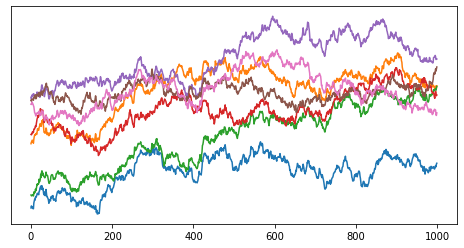

In [85]:
T = 1000 # the length of the time series
n_procs = 7 # the number of time series
rho = 0.7 # correlation

p_mat = get_simulated_paths_array(T, n_procs, rho, random_state=264)

#--------------------------------
# plot

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

plt.plot(p_mat)
plt.yticks([])

Given “p_mat” where each column is a time series and our weight vector w, the resulting time series S can be calulated using:

In [86]:
def get_St(w_vec: np.ndarray, p_mat: np.ndarray) -> np.ndarray:
    return np.dot(w_vec, p_mat.T)

Finally the example of the Canonical Decomposition using Sklearn OLS to implement the “RegressionModel” interface with no intercept and max_lag=1

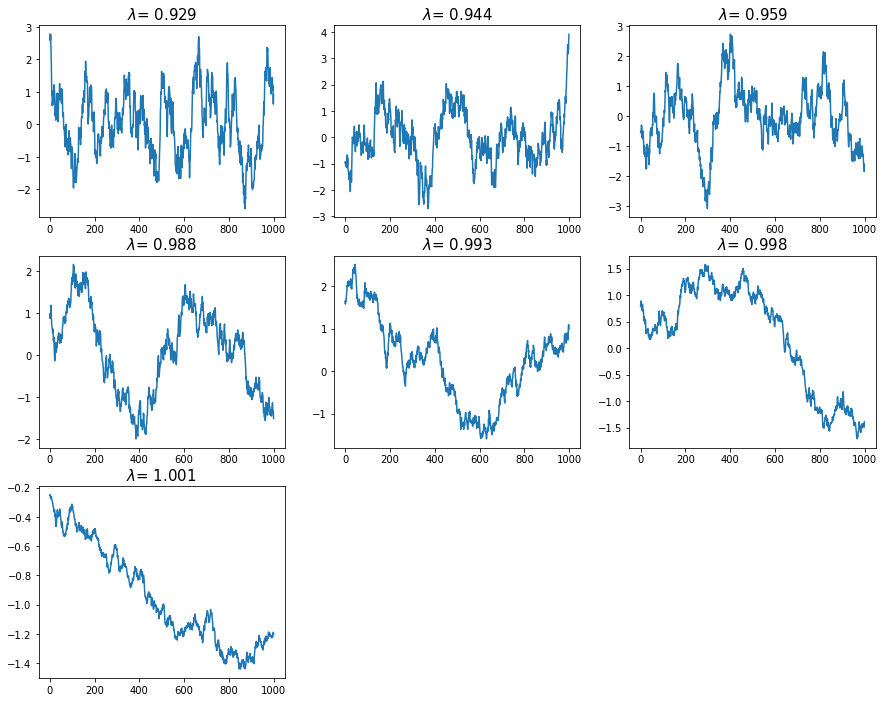

In [87]:
# regression model
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression(fit_intercept=False)

# use the regression model instance as argument for decompose function.
can_decomp_solution = decompose(p_mat, regression_model, max_lag=1)

#--------------------------------
# plot

import math

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
n_decomps = len(can_decomp_solution.lambdas)
n_graph_cols = 3
n_graph_rows = math.ceil(n_decomps / n_graph_cols)

for j in range(n_decomps):
    lambda_j = can_decomp_solution.lambdas[j]
    w_vec = can_decomp_solution.w_vecs[:, j]
    plt.subplot(n_graph_rows, n_graph_cols, j+1)
    S_t = get_St(w_vec, p_mat)
    plt.plot(S_t)
    subplot_title = r"$\lambda$= " + "{:.3f}".format(lambda_j)
    plt.gca().set_title(subplot_title, fontsize=15)
    
plt.show()

To illustrate how easy is to use another type of regression, let us now use Sklearn’s elastic net and set max_lag to 9.

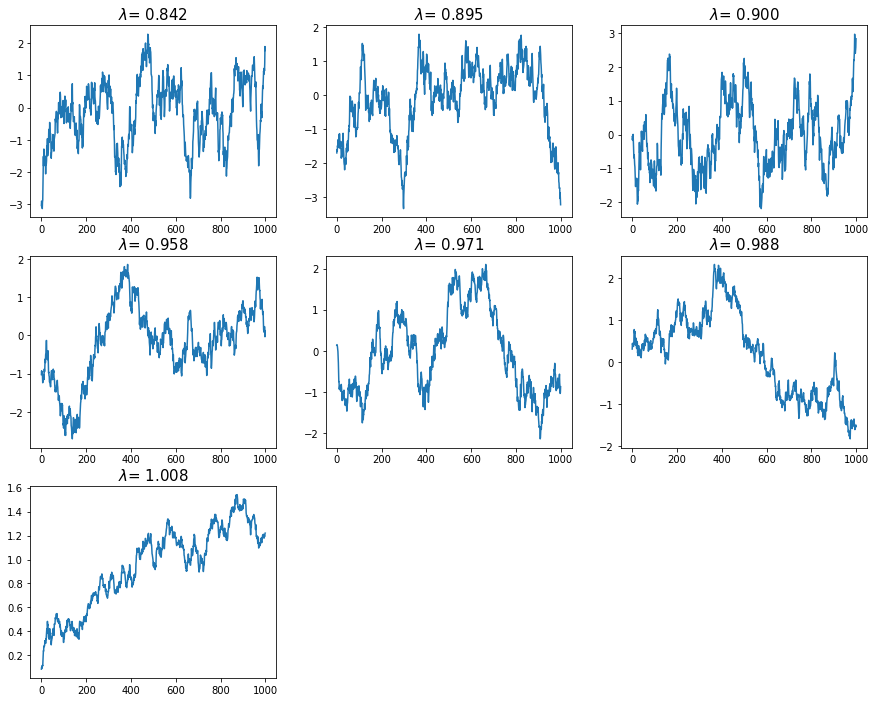

In [88]:
# regression model
from sklearn.linear_model import ElasticNet

regression_model = ElasticNet()

# use the regression model instance as argument for decompose function.
can_decomp_solution = decompose(p_mat, regression_model, max_lag=9)


#--------------------------------
# plot

import math

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
n_decomps = len(can_decomp_solution.lambdas)
n_graph_cols = 3
n_graph_rows = math.ceil(n_decomps / n_graph_cols)

for j in range(n_decomps):
    lambda_j = can_decomp_solution.lambdas[j]
    w_vec = can_decomp_solution.w_vecs[:, j]
    plt.subplot(n_graph_rows, n_graph_cols, j+1)
    S_t = get_St(w_vec, p_mat)
    plt.plot(S_t)
    subplot_title = r"$\lambda$= " + "{:.3f}".format(lambda_j)
    plt.gca().set_title(subplot_title, fontsize=15)

plt.show()

## Final Words

We have successfully coded a library for BTCD, which in my view fills a gap in most time series statistical libraries. Now you have another tool for cointegration analysis besides Engle-Granger and Johansen.

The main goal of creating an interface for the regression model and not coding it directly is for you to use and fine-tune the regression model that works best with your data. However, if don’t want to tinker with this then use OLS as Box and Tiao originally intended.

The main problem with cointegration methods and BTCD as well is that they are prone to overfitting. This is why it is important to use a suitable regression model for your data. If you didn’t notice we used correlated random walks (discrete Brownian motions) as an example, the fact that the decomposition works with such data is proof of overfitting. For any not trivial linear combination of Brownian motions (even if they are correlated) is a rescaled Brownian motion which is by no means stationary nor trending for that matter, there is no cointegration for such combination. This is extremely important especially when cointegration is used to make predictions such as in statistical arbitrage trading applications. Sadly most of these methods will overfit the data, but hopefully, you can find the regression model that works best for you.

The predictability value λ is dependent on the regression model, so there is no meaningful comparison between lambdas calculated with different regression models, hence is not an absolute measure, it is only meaningful for comparison when using the same regression model.

# Dickey-Fuller Optimization: Tackle Time Series Cointegration Head-on

We will code a method comparable in speed to the Johansen method and BTCD and with the same or even more reliability. However, there will be some math involved, so be warned. To successfully optimize the function (and not take forever), we will calculate the gradient and the Hessian matrix for the Dickey-Fuller test statistic.

## Cointegration, problem setting

Cointegration, in practical terms, refers to multiple time series (processes) integrated of order 1. That is to say that there is a linear combination of those time series (another time series) that is stationary. Who does not love stationary time series?

Mathematically, given N time series P_i, i=1,2, .., .N, with sample size T+1, we are trying to find a vector w with components w_i such that the linear combination:

$$ S_t = \sum_{i = 1}^{N} w_{i}P_{t,i} $$
is stationary.

Given the vector w (“w_vec”) and the processes P_i, encoded as a matrix (“p_mat”) with one process in each column getting S is very simple:

In [27]:
import numpy as np

def get_S_t(w_vec: np.ndarray, p_mat: np.ndarray) -> np.ndarray:
    """
    Get a the time series from the linear combination of w_vec and the
    processes (time series) in p_mat.
    - w_vec is a numpy 1D array of shape (N,)
    - p_mat is a numpy 2D array of shape (T+1, N)
    Returns:
        1D numpy array
    """
    return np.dot(w_vec, p_mat.T)

## Dickey-Fuller statistic, direct estimation

The first thing we will address is optimizing the function call speed. Usually, to calculate the Dickey-Fuller test, we would do OLS regression. That is expensive. Instead, we use a direct estimation for the test statistic:

$$ DF = \sqrt{T-2/1-\rho_{S_{L},S_{d}}^2}  \rho_{S_{L},S_{d}} $$

Where $\rho_{S_{L},S_{d}}$ is the pearson correlation for the lagged S series $S_{L}$ and the differenced S series $S_{d}$


Using the Dickey-Fuller statistic in this form is faster since calculating the correlation coefficient is computationally more efficient than OLS matrix inversions and multiplications. Furthermore, it has another advantage; the dependence of the statistic on the vector w is clear. Since the correlation is:

$$\rho_{S_{L},S_{d}} = \sigma_{S_{L},S_{d}}/\sigma_{S_{d}}\sigma_{S_{L}}$$

and the covariance and the variance of $S_{L}$ and $S_{d}$ can be written as quadratic forms using covariance matrices and the w vector: 

$$ \sigma_{S_{L}}^2 = w^T V_{L} w $$
$$ \sigma_{S_{d}}^2 = w^T V_{d} w $$

and $$\sigma_{S_{L},S_{d}} = w^T V_{L,d} w = w^T V_{d,L} w$$


where V_L is the covariance matrix of the lagged P_i time series, V_d is the covariance matrix of the differenced P_i time series, V_L,d and V_d,L are cross-covariance matrices for the lagged and differenced time series, they are defined as:

$$ [V_{d,L}]_{i,j} = cov(P_{L,i}, P_{d,j}) $$
$$ [V_{L,d}]_{i,j} = cov(P_{d,i}, P_{L,j}) $$
$$ V_{d,L}^T = V_{L,d} 

In [20]:
from dataclasses import dataclass

@dataclass
class _SInit:
    S_t: np.ndarray
    S_d: np.ndarray
    S_L: np.ndarray
    T: int
    rho: float


def _get_S_init(w_vec: np.ndarray, p_mat: np.ndarray) -> _SInit:
    """Create and populate _SInit data model."""
    S_t = get_S_t(w_vec, p_mat)
    S_d = np.diff(S_t)
    S_L = S_t[:-1]
    return _SInit(
        S_t=S_t,
        S_d=S_d,
        S_L=S_L,
        T=len(S_t) - 1,
        rho=float(np.corrcoef(S_L, S_d)[0, 1]),
    )

@dataclass
class _PCovMatrices:
    V_p: np.ndarray
    V_d: np.ndarray
    V_L: np.ndarray
    V_dL: np.ndarray
    V_Ld: np.ndarray


def _get_P_cov_matrices(p_mat: np.ndarray) -> _PCovMatrices:
    """
    Create and populate the covariance matrices data model  _PCovMatrices
    """
    N = p_mat.shape[1]
    P_d = np.diff(p_mat, axis=0)
    P_L = p_mat[:-1, :]
    ext_V_dL = np.cov(np.concatenate([P_d, P_L], axis=1), rowvar=False)
    return _PCovMatrices(
        V_p=np.cov(p_mat, rowvar=False),
        V_d=ext_V_dL[:N, :N],
        V_L=ext_V_dL[N:, N:],
        V_dL=ext_V_dL[:N, N:],
        V_Ld=ext_V_dL[N:, :N],
    )
    
@dataclass
class _SigmasSdSL:
    sigma_S_d: float
    sigma_S_L: float


def _get_sigmas_S_d_S_L(S_init: _SInit) -> _SigmasSdSL:
    """
    Create and populate the standard deviations object for S_d and S_L.
    """
    return _SigmasSdSL(
        sigma_S_d=float(np.std(S_init.S_d)),
        sigma_S_L=float(np.std(S_init.S_L)),
    )
    
# With the initial objects coded we can now state our objective function, the 
# Dickey-Fuller statistic direct estimation:

def _get_DF(w_vec: np.ndarray, p_mat: np.ndarray) -> float:
    """
    Dickey Fuller Direct estimation.
    - w_vec is 1D numpy array of shape is (N,)
    - p_mat is a 2D numpy array of shape is (T+1, N)
    Returns:
        the estimated number (float) for Dickey Fuller test statistic.
    """
    s_init = _get_S_init(w_vec, p_mat)
    T = s_init.T
    rho = s_init.rho
    return float(np.sqrt((T - 2) / (1 - rho ** 2)) * rho)

## The gradient


The gradient of DF (Dickey-Fuller) with respect to w is:

$$ \bigtriangledown_{w}DF =  \sqrt{T-2/((1-\rho_{S_{L},S_{d}}^2})^3  \bigtriangledown_{w}\rho_{S_{L},S_{d}} $$

In [21]:
def _get_DF_gradient(
    w_vec: np.ndarray, p_mat: np.ndarray, P_cov_matrices: _PCovMatrices
) -> np.ndarray:
    """
    Calculate the Dickey Fuller gradient vector.
    - w_vec is a numpy 1D array of shape (N,)
    - p_mat is a numpy 2D array of shape (T+1, N)
    - P_cov_matrices is an instance of _PCovMatrices
    Returns:
        1D numpy array with the gradient with respect to w_vec
    """
    S_init = _get_S_init(w_vec, p_mat)
    rho = S_init.rho
    sigmas_S_L_S_d = _get_sigmas_S_d_S_L(S_init)
    rho_gradient = _get_rho_gradient(
        w_vec, P_cov_matrices, sigmas_S_L_S_d, S_init.rho
    )
    T = S_init.T
    return (
        np.sqrt((T - 2) / (1 - rho ** 2))
        * (1 + (rho ** 2) / (1 - rho ** 2))
        * rho_gradient
    )


def _get_rho_gradient(
    w_vec: np.ndarray,
    P_cov_matrices: _PCovMatrices,
    sigmas_S_L_S_d: _SigmasSdSL,
    rho: float,
) -> np.ndarray:
    """
    Calculate the gradient vector of rho (the correlation of S_d and S_L)
    - w_vec is a numpy 1D array of shape (N,)
    - P_cov_matrices is an instance of _PCovMatrices
    - sigmas_S_L_S_d is an instance of _SigmasSdSL
        (standard deviations for S_d and S_L)
    - rho is the correlation of S_d and S_L at w_vec
    Returns:
        1D numpy array with the gradient with respect to w_vec
    """
    sigma_S_d = sigmas_S_L_S_d.sigma_S_d
    sigma_S_L = sigmas_S_L_S_d.sigma_S_L
    term_1 = np.matmul(P_cov_matrices.V_Ld + P_cov_matrices.V_dL, w_vec) / (
        sigma_S_L * sigma_S_d
    )
    term_2 = -rho * np.matmul(
        P_cov_matrices.V_L / sigma_S_L ** 2
        + P_cov_matrices.V_d / sigma_S_d ** 2,
        w_vec,
    )
    return term_1 + term_2

## The Hessian matrix

To get the Hessian matrix, we will use tensor calculus because we will need to deal with the derivative of a matrix with respect to a vector and funky math of the sort, so tensor calculus is best suited.

We will use Einstein’s summation convention of repeated indices; sum signs would complicate everything further because we have many indices. Furthermore, we will use the following simplification:

$$ \rho_{S{L},S{d}} \to \rho $$

In the covariance matrices, we will use the subscript field for indices:

$$ V_{L} \to V^L $$
$$ V_{d} \to V^d $$

The Hessian is: 

$$ H(DF)_{\gamma \alpha}  =  \partial_{\gamma}\partial_{\alpha} DF =  \sqrt{T-2/((1-\rho^2})^3 (\partial_{\gamma}\partial_{\alpha}\rho + (3\rho(\partial_{\gamma}\rho\partial_{\alpha}\rho)/1-\rho^2))$$

In [22]:
def _get_hessian_DF(
    w_vec: np.ndarray, p_mat: np.ndarray, P_cov_matrices: _PCovMatrices
) -> np.ndarray:
    """
    Calculate the Dickey Fuller Hessian matrix.
    - w_vec is a numpy 1D array of shape (N,)
    - p_mat is a numpy 2D array of shape (T+1, N)
    - P_cov_matrices is an instance of _PCovMatrices
    Returns:
        2D numpy array with the Hessian with respect to w_vec
    """
    S_init = _get_S_init(w_vec, p_mat)
    rho = S_init.rho
    sigmas_S_L_S_d = _get_sigmas_S_d_S_L(S_init)
    grad_rho = _get_rho_gradient(w_vec, P_cov_matrices, sigmas_S_L_S_d, rho)
    T = S_init.T
    hessian_rho = _get_hessian_rho(w_vec, P_cov_matrices, sigmas_S_L_S_d, rho)
    return np.sqrt((T - 2) / (1 - rho ** 2) ** 3) * (
        hessian_rho
        + (3 * rho / (1 - rho ** 2)) * np.outer(grad_rho.T, grad_rho)
    )


def _get_hessian_rho(
    w_vec: np.ndarray,
    P_cov_matrices: _PCovMatrices,
    sigmas_S_L_S_d: _SigmasSdSL,
    rho: float,
) -> np.ndarray:
    """
    Calculate the Hessian matrix of rho (the correlation of S_d and S_L)
    - w_vec is a numpy 1D array of shape (N,)
    - P_cov_matrices is an instance of _PCovMatrices
    - sigmas_S_L_S_d is an instance of _SigmasSdSL
        (standard deviations for S_d and S_L)
    - rho is the correlation of S_d and S_L at w_vec
    Returns:
        2D numpy array with the Hessian with respect to w_vec
    """
    sigma_S_d = sigmas_S_L_S_d.sigma_S_d
    sigma_S_L = sigmas_S_L_S_d.sigma_S_L
    V_L = P_cov_matrices.V_L
    V_d = P_cov_matrices.V_d
    V_dL = P_cov_matrices.V_dL
    V_Ld = P_cov_matrices.V_Ld

    G = V_L / (sigma_S_L ** 2) + V_d / (sigma_S_d ** 2)
    K = V_dL + V_Ld
    Q_4tensor = (
        np.einsum("ng,ma -> ngma", V_L, V_L) / sigma_S_L ** 4
        + np.einsum("ng,ma -> ngma", V_d, V_d) / sigma_S_d ** 4
    )
    term_1 = (1.0 / (sigma_S_L * sigma_S_d)) * (
        K
        - np.einsum("n, m, ma, ng -> ga", w_vec, w_vec, K, G)
        - np.einsum("n, m, ma, ng -> ga", w_vec, w_vec, G, K)
    )
    term_2 = rho * (
        np.einsum("n, m, ng, ma -> ga", w_vec, w_vec, G, G)
        + 2 * np.einsum("n, m, ngma -> ga", w_vec, w_vec, Q_4tensor)
        - G
    )
    return term_1 + term_2

## Minimization

The minimization code block is very straightforward once we have the objective function, the gradient, and the Hessian. Essentially we wrap SciPy’s minimize function with the arguments of our cointegration problem:

- “p_mat” is the P_i processes matrix.
- “w_vec_init” is an initial guess for w_vec. Don’t worry if you don’t supply one; a random guess will be generated.
- “method” can only take two values, either “trust-krylov” or “trust-exact”.

Note: This is not a global optimizer, so giving an initial w vector is essential for convergence. In some problems, the randomly picked vector is enough for convergence. However, it would be best to generate a better initial guess for your particular situation.



In [23]:
from typing import Optional, Literal
from scipy.optimize import minimize


def minimize_DF(
    p_mat: np.ndarray,
    w_vec_init: Optional[np.ndarray] = None,
    method: Literal["trust-krylov", "trust-exact"] = "trust-krylov",
) -> np.ndarray:
    """
    Cointegration w_vec by direct minimization of the Dickey Fuller statistic.
    - p_mat is a numpy 2D array of shape (T+1, N)
    - w_vec_init is a numpy 1D array (N,) or None, it is the initial guess for
        w_vec, if it is None a random guess will be generated
    - method, choose between scipy minimize methods "trust-krylov", "trust-exact"
        for unconstrained optimization with gradient hessian
    Returns:
        w_vec -> numpy 1D array
    """
    w_vec_0 = _get_w_vec_0(w_vec_init, p_mat)
    P_cov_matrices = _get_P_cov_matrices(p_mat)
    opt_result = minimize(
        lambda w_vec: _get_DF(w_vec, p_mat),
        x0=w_vec_0,
        method=method,
        jac=lambda w_vec: _get_DF_gradient(w_vec, p_mat, P_cov_matrices),
        hess=lambda w_vec: _get_hessian_DF(w_vec, p_mat, P_cov_matrices),
    )
    return opt_result.x


def _get_w_vec_0(
    w_vec_init: Optional[np.ndarray], p_mat: np.ndarray
) -> np.ndarray:
    """
    Get best guess for w_vec, a random array if w_vec_init is None,
    else returns w_vec_init
    """
    if w_vec_init is None:
        return np.random.default_rng().random(p_mat.shape[1])
    return w_vec_init

### Testing

In [25]:
from typing import Optional

import numpy as np

def get_brownian_paths(
    T: int, 
    n_procs: int, 
    rho: Optional[float] = None, 
    random_state: Optional[int] = None
) -> np.ndarray:
    """Generate paths (cumsum) from brownian correlated increments."""
    corr_dWs = get_corr_dW_matrix(T, n_procs, rho, random_state)
    return np.cumsum(corr_dWs, axis=0)

([], [])

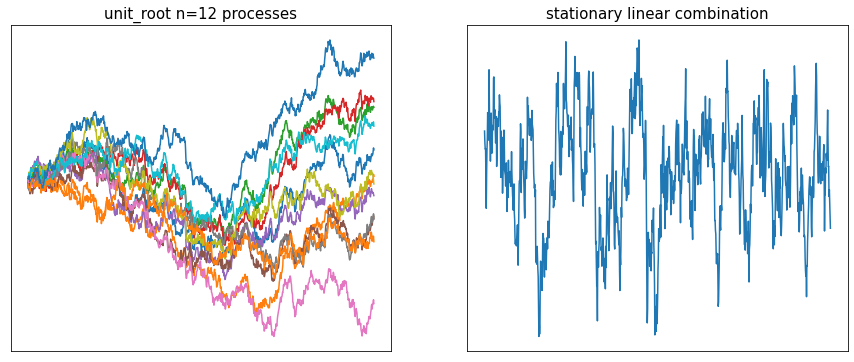

In [28]:
# generate unit root processes matrix
p_mat = get_brownian_paths(T=1_000, n_procs=12, rho=0.8)

w_vec_minmized = minimize_DF(p_mat)

S_minimized = get_S_t(w_vec_minmized, p_mat)

#----------------------------------------------------------------
# plot

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 6))

title = f"unit_root n={p_mat.shape[1]} processes"
plt.subplot(1, 2, 1)
plt.plot(p_mat)
plt.gca().set_title(title, fontsize=15)
plt.xticks([])
plt.yticks([])

title = f"stationary linear combination"
plt.subplot(1, 2, 2)
plt.plot(S_minimized)
plt.gca().set_title(title, fontsize=15)
plt.xticks([])
plt.yticks([])